In [ ]:
import re, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import networkx as nx

from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD

np.random.seed(42)

In [ ]:
df = pd.read_excel('data/final_risk_data.xlsx')

# изменение типов данных
df['date'] = pd.to_datetime(df['date']).dt.normalize()
for i in ['debit_amount', 'credit_amount']:
    if i in df.columns:
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
# создание колонки с суммой операции
df["amount"] = np.where(df["debit_amount"].notna(), df["debit_amount"], df["credit_amount"])
df["debit_amount"] = df["debit_amount"].fillna(0.0)
df["credit_amount"] = df["credit_amount"].fillna(0.0)

# созжание временных признаков
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
df['month'] = df['date'].dt.month
df["weekofyear"]   = df["date"].dt.isocalendar().week.astype(int)

# Суточные фичи
df['daily_total_debit'] = df.groupby(['debit_inn', 'date'])['debit_amount'].transform('sum')
df['daily_total_credit'] = df.groupby(['credit_inn', 'date'])['credit_amount'].transform('sum')
# посчет транзакций за сутки
df["daily_debit_transaction_count"]    = df.groupby(["debit_inn","date"])["debit_amount"].transform(lambda s: (s > 0).sum())
df["daily_credit_transaction_count"]    = df.groupby(["credit_inn","date"])["credit_amount"].transform(lambda s: (s > 0).sum())
# уникальные отправители и получатели в сутки
df["unique_recipients_per_day"] = df.groupby(["debit_inn","date"])["credit_inn"].transform("nunique")
df["unique_receivers_per_day"] = df.groupby(["credit_inn","date"])["debit_inn"].transform("nunique")

# Доля текущей операции в суточном объёме
df["daily_debit_percent"] = (df["debit_amount"] / df["daily_total_debit"].replace(0, np.nan)).fillna(0.0)
df["daily_credit_percent"] = (df["credit_amount"] / df["daily_total_credit"].replace(0, np.nan)).fillna(0.0)

# Интервалы между операциями (в днях)
df["days_since_last_txn_debit"]  = df.groupby("debit_inn")["date"].diff().dt.days.fillna(9999)
df["days_since_last_txn_credit"] = df.groupby("credit_inn")["date"].diff().dt.days.fillna(9999)

def add_rolling_side(df: pd.DataFrame,
                     side: str,
                     amt_col: str,
                     windows=(7, 14, 30, 90)) -> pd.DataFrame:
    """
    Создает роллинги по суммам/кол-ву транзакций за окна windows для заданной стороны.
    side: 'debit' или 'credit'
    amt_col: имя столбца с суммой для этой стороны (например, 'debit_amount' / 'credit_amount')
    """
    inn_col = f"{side}_inn"
    out_parts = []

    # Берем только нужные колонки (ускоряет groupby)
    need_cols = [inn_col, "date", amt_col]
    sub_all = df[need_cols].copy()
    sub_all[amt_col] = sub_all[amt_col].fillna(0.0)

    for inn, sub in sub_all.groupby(inn_col, sort=False):
        # суточная агрегация по аккаунту
        daily = (sub.groupby("date", as_index=True)[amt_col]
                   .sum()
                   .to_frame("amt_day")
                   .sort_index())

        # непрерывный календарный индекс (чтобы окна не "сжимались")
        idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
        daily = daily.reindex(idx, fill_value=0.0)
        daily.index.name = "date"

        # индикатор "была ли операция в день" (для роллинга количества)
        daily["tx_day"] = (daily["amt_day"] > 0).astype(int)

        # роллинги
        for W in windows:
            daily[f"{side}_roll_sum_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).sum()
            daily[f"{side}_roll_cnt_{W}d"]  = daily["tx_day"].rolling(W, min_periods=1).sum()
            daily[f"{side}_roll_mean_{W}d"] = daily["amt_day"].rolling(W, min_periods=1).mean()
            daily[f"{side}_roll_std_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).std().fillna(0.0)
            daily[f"{side}_roll_p95_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).quantile(0.95)

        daily = daily.reset_index()
        daily[inn_col] = inn
        out_parts.append(daily[["date", inn_col] + [c for c in daily.columns if c.startswith(f"{side}_roll_")]])

    rolls = pd.concat(out_parts, ignore_index=True)
    return df.merge(rolls, on=["date", inn_col], how="left")



# Новые роллинги 7/14/30/90 для дебета и кредита
WINDOWS = (7, 14, 30, 90)
df = add_rolling_side(df, side="debit",  amt_col="debit_amount",  windows=WINDOWS)
df = add_rolling_side(df, side="credit", amt_col="credit_amount", windows=WINDOWS)

# ==== 1. Всплески сумм (amount_spike_ratio_7d) ====
df["debit_amount_spike_ratio_7d"]  = df["debit_roll_sum_7d"]  / (df["debit_roll_sum_30d"]/4 + 1e-6)
df["credit_amount_spike_ratio_7d"] = df["credit_roll_sum_7d"] / (df["credit_roll_sum_30d"]/4 + 1e-6)

# ==== 2. Всплески активности (tx_rate_spike_7d) ====
df["debit_tx_rate_spike_7d"]  = df["debit_roll_cnt_7d"]  / (df["debit_roll_cnt_30d"]/4 + 1e-6)
df["credit_tx_rate_spike_7d"] = df["credit_roll_cnt_7d"] / (df["credit_roll_cnt_30d"]/4 + 1e-6)

# ==== 3. Fan-out / Fan-in (уникальные контрагенты) ====
# Для дебета — fan-out (сколько разных получателей на операцию)
df["debit_fan_out_ratio"] = df["unique_recipients_per_day"] / (df["daily_debit_transaction_count"] + 1e-6)

# Для кредита — fan-in (сколько разных отправителей на операцию)
df["credit_fan_in_ratio"] = (
    df.groupby(["credit_inn", "date"])["debit_inn"].transform("nunique") /
    (df["daily_credit_transaction_count"] + 1e-6)
)

# ==== 4. Дисбаланс потоков (in_out_ratio_30d) ====
df["in_out_ratio_30d"] = (df["credit_roll_sum_30d"] + 1e-6) / (df["debit_roll_sum_30d"] + 1e-6)

# ==== 5. Волатильность объёмов (amount_volatility_30d) ====
df["debit_amount_volatility_30d"]  = df["debit_roll_std_30d"]  / (df["debit_roll_mean_30d"]  + 1e-6)
df["credit_amount_volatility_30d"] = df["credit_roll_std_30d"] / (df["credit_roll_mean_30d"] + 1e-6)


# Круглые суммы
df["round_10k"]  = ((df["amount"] % 10000)  == 0).astype(int)
df["round_100k"] = ((df["amount"] % 100000) == 0).astype(int)
df["round_large_amount"] = ((df["round_10k"]==1) | (df["round_100k"]==1)).astype(int)

df.head()

In [ ]:
df.columns

In [ ]:
# ============================================================
#  Анализ "Назначения платежа": FRIDA + TF-IDF + флаги риска (regex + SVD)
# ============================================================

import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer

# ------------------------------------------------------------
# 1) Регулярные паттерны высокого риска
# ------------------------------------------------------------
STOP_HIGH_PATTERNS = [
    r"\bзайм\w*\b", r"\bвозврат\W*(займ|долг)\w*\b", r"\bпогашен\w*\W*(займ|долг)\w*\b",
    r"\bдолг\w*\b", r"\bоплат\w*\W*(займ|долг)\w*\b",
    r"\bкрипт\w*\b", r"\bбиткоин\w*\b", r"\busdt\b", r"\bbtc\b", r"\bcoin\b",
    r"\bбирж\w*\b", r"\bобмен\w*\b", r"\bвалют\w*\b",
    r"\bналич\w*\b", r"\bобнал\w*\b", r"\bвыдач\w*\W*налич\w*\b",
    r"\bперевод\w*\W*(на|с)\W*карт\w*\b", r"\bперевод\w*\W*физ\w*\b",
    r"\bперевод\w*\W*родствен\w*\b", r"\bперевод\w*\W*средств\b",
    r"\bбез\W*договор\w*\b",
    r"\bпожертв\w*\b", r"\bблаготвор\w*\b", r"\bдарен\w*\b",
    r"\bагентск\w*\W*вознагражд\w*\b", r"\bкомисси\w*\W*вознагражд\w*\b",
    r"\bвознагражд\w*\b",
    r"\bцесс\w*\b", r"\bпоручител\w*\b", r"\bзалог\w*\b",
    r"\bофшор\w*\b", r"\bиностран\w*\W*перевод\w*\b", r"\bswift\b",
    r"\bличн\w*\W*нужд\w*\b", r"\bпередач\w*\W*актив\w*\b",
    r"\bвклад\w*\b", r"\bдепозит\w*\b",
]
STOP_HIGH_RE = re.compile("|".join(STOP_HIGH_PATTERNS), flags=re.IGNORECASE)


# ------------------------------------------------------------
# 3) Очистка
# ------------------------------------------------------------
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[^a-zа-я0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["purpose_clean"] = df["purpose"].apply(clean_text)

# ------------------------------------------------------------
# 4) Флаги риска
# ------------------------------------------------------------
df["purpose_stopword_high"] = df["purpose_clean"].str.contains(STOP_HIGH_RE, na=False)
df["digit_share"]    = df["purpose_clean"].apply(lambda x: sum(c.isdigit() for c in x) / max(len(x), 1))
df["purpose_len"]    = df["purpose_clean"].apply(len)
df["has_contract_no"]= df["purpose"].str.contains(r"№\s*\d+", regex=True, na=False)
df["is_foreign_lang"]= df["purpose"].str.contains(r"[a-zA-Z]", na=False)

# ------------------------------------------------------------
# 5) FRIDA embeddings (+ PCA до 64)
# ------------------------------------------------------------
print("⚙️ Загружаем FRIDA...")
model = SentenceTransformer("ai-forever/FRIDA")

# кодируем именно тексты из df
E = model.encode(df["purpose_clean"].tolist(), convert_to_numpy=True, normalize_embeddings=True)

# безопасное число компонент для PCA
n_components = min(64, E.shape[0], E.shape[1])
pca = PCA(n_components=n_components, random_state=42)
E_pca = pca.fit_transform(E)

# проверка размерностей
assert E_pca.shape[0] == len(df), "Количество эмбеддингов не совпадает с количеством строк df"

# Добавляем PCA-компоненты в df
for i in range(E_pca.shape[1]):
    df[f"purpose_emb_pca_{i+1}"] = E_pca[:, i]

print(f"✅ PCA добавлен: {E_pca.shape[1]} компонент")

# Добавим (опционально) эти признаки в df для отладки/аналитики
for i in range(E_pca.shape[1]):
    df[f"purpose_emb_pca_{i+1}"] = E_pca[:, i]

# ------------------------------------------------------------
# 6) TF-IDF (char 3–5)  +  SVD до k компонент  →  колонки в df
# ------------------------------------------------------------
texts = df["purpose_clean"].astype(str).tolist()
tfidf = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=1)
X_tfidf = tfidf.fit_transform(texts)  # [n_samples, vocab_size]

# целевое число компонент (желание)
svd_k_target = 50

# безопасное число компонент: не больше размеров матрицы
# (минимум 1, максимум допустимое)
max_svd = max(1, min(X_tfidf.shape[0] - 1, X_tfidf.shape[1] - 1))
n_svd = min(svd_k_target, max_svd)

svd = TruncatedSVD(n_components=n_svd, random_state=42)
X_svd = svd.fit_transform(X_tfidf)  # [n_samples, n_svd]

# кладём SVD-компоненты по фактическому числу столбцов
for i in range(X_svd.shape[1]):
    df[f"purpose_svd_{i+1}"] = X_svd[:, i]

expl_var = svd.explained_variance_ratio_.sum()
print(f"SVD explained variance (k={X_svd.shape[1]}): {expl_var:.3f}")


# ------------------------------------------------------------
# 7) Weak-label классификатор (демо)
#    Обучаемся на FRIDA(PCA) + простых флагах + SVD-компонентах
# ------------------------------------------------------------
y_weak = df["purpose_stopword_high"].astype(int).values

X_dense = np.hstack([
    E_pca,                                            # 64
    df[["digit_share","purpose_len","has_contract_no","is_foreign_lang"]].values,  # 4
    X_svd                                             # k
])

clf = LogisticRegression(max_iter=2000, class_weight="balanced")
clf.fit(X_dense, y_weak)
df["text_susp_score"] = clf.predict_proba(X_dense)[:, 1]

# ------------------------------------------------------------
# 8) Итоговый скор и красный флаг
# ------------------------------------------------------------
df["purpose_risk_score"] = (
    0.6 * df["text_susp_score"] +
    0.4 * df["purpose_stopword_high"].astype(float)
)
df["red_flag"] = df["purpose_risk_score"] > 0.7

# ------------------------------------------------------------
# 9) Результат
# ------------------------------------------------------------
svd_cols = [c for c in df.columns if c.startswith("purpose_svd_")]

cols_show = [
    "purpose", "purpose_stopword_high", "text_susp_score",
    "purpose_risk_score", "red_flag"
] + svd_cols

print("\n=== Результат анализа назначений (+ SVD) ===")
print(df[cols_show])


---

Тест модели слабых меток

In [58]:
def generate_weak_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Создает слабые метки подозрительных операций по критериям ЦБ РФ и AML-типологиям.
    Добавляет в DataFrame колонки:
        y_weak — бинарная слабая метка (1 = подозрительно)
        y_reg  — плавная уверенность [0–1]
    """

    def calc_row_score(row):
        score = 0.0

        #  Всплески активности и волатильность
        for f in ["debit_amount_spike_ratio_7d", "credit_amount_spike_ratio_7d",
                  "debit_tx_rate_spike_7d", "credit_tx_rate_spike_7d"]:
            if row.get(f, 0) > 1.5: score += 1
        for f in ["debit_amount_volatility_30d", "credit_amount_volatility_30d"]:
            if row.get(f, 0) > 1.0: score += 1

        

        #  Дисбаланс потоков
        ratio = row.get("in_out_ratio_30d", 1)
        if ratio < 0.5 or ratio > 2.0: score += 1
        if row.get("daily_debit_percent", 0) > 0.8: score += 1
        if row.get("daily_credit_percent", 0) > 0.8: score += 1

        #  Поведенческие признаки
        if row.get("days_since_last_txn_debit", 0) > 30: score += 1
        if row.get("days_since_last_txn_credit", 0) > 30: score += 1
        if row.get("debit_roll_cnt_30d", 0) > 100: score += 1
        if row.get("credit_roll_cnt_30d", 0) > 100: score += 1

        #  Дробление и округлость
        if row.get("round_10k", 0) == 1 or row.get("round_100k", 0) == 1 or row.get("round_large_amount", 0) == 1:
            score += 1

        

        # --- Итог ---
        weak_label = 1 if score >= 5 else 0
        weak_score = min(score / 10.0, 1.0)

        return pd.Series({"y_weak": weak_label, "y_reg": weak_score})

    print("⚙️ Генерация слабых меток (weak labels)...")
    weak_df = df.apply(calc_row_score, axis=1)
    df = pd.concat([df, weak_df], axis=1)
    print(f"✅ Добавлены колонки: y_weak, y_reg. Подозрительных операций: {df['y_weak'].sum()} из {len(df)}")
    return df


In [59]:
df_test = df.copy()
df_test = generate_weak_labels(df_test)

df_test['y_weak'].value_counts()

⚙️ Генерация слабых меток (weak labels)...
✅ Добавлены колонки: y_weak, y_reg. Подозрительных операций: 294.0 из 2688


y_weak
0.0    2394
1.0     294
Name: count, dtype: int64

In [62]:
df_test[df_test['y_weak']==1].head(50)

,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,...,purpose_svd_46,purpose_svd_47,purpose_svd_48,purpose_svd_49,purpose_svd_50,text_susp_score,purpose_risk_score,red_flag,y_weak,y_reg
0,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0c00203649ed677a,e19cc80da09f445f,8d9e0be733f77f1c,10.0,0.0,комиссия внутри сбербанка за пп/пт через дбо с...,...,-0.036128,0.053308,0.011304,0.017456,-0.036059,0.018705,0.011223,False,1.0,0.5
1,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,7682fd5c32e028f5,796a88c244ffcc0a,6931e23e98703aa9,3000000.0,0.0,оплата по счету № 28 от date_9f241b636025 по д...,...,0.001957,0.057884,0.071135,-0.020898,-0.019666,0.041653,0.024992,False,1.0,0.6
3,2019-01-10,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,e63cf19b76230a3d,21a73421ca00ae87,eed8b1f54ed4366c,4282.0,0.0,оплата по договору электроэнергия по дог.№1124...,...,-0.036073,-0.033184,-0.030233,-0.020877,-0.016197,0.013642,0.008185,False,1.0,0.6
4,2019-01-10,d658b4e51c5a5df5,f7185cc66db08da5,ad57c94e5b8df8f6,ded93f97f389bf2c,3e368a63959d285e,d877722ca4e40f98,0.0,1000000.0,перевод денежных средств по договору займа № ч...,...,0.014429,0.008402,-0.012429,0.052898,0.009185,0.704201,0.822521,True,1.0,0.6
5,2019-01-10,c56ed5f61773e096,5db06c0389d83402,1c3f31b0b8c13d69,ded93f97f389bf2c,3e368a63959d285e,d877722ca4e40f98,0.0,2000000.0,перевод денежных средств по договору № пи-1/10...,...,0.006681,-0.019719,-0.011390,0.004796,-0.004301,0.163284,0.097970,False,1.0,0.5
7,2019-01-11,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,7682fd5c32e028f5,796a88c244ffcc0a,6931e23e98703aa9,3000000.0,0.0,оплата по счету № 28 от date_9f241b636025 по д...,...,0.001957,0.057884,0.071135,-0.020898,-0.019666,0.041653,0.024992,False,1.0,0.5
9,2019-01-14,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,7682fd5c32e028f5,796a88c244ffcc0a,6931e23e98703aa9,6000000.0,0.0,оплата по счету № 2 от date_168616af7e96 аванс...,...,-0.012525,0.019290,0.061342,0.005708,-0.094155,0.017643,0.010586,False,1.0,0.6
10,2019-01-14,d658b4e51c5a5df5,f7185cc66db08da5,ad57c94e5b8df8f6,ded93f97f389bf2c,3e368a63959d285e,d877722ca4e40f98,0.0,1700000.0,перевод денежных средств по договору займа № ч...,...,0.031777,-0.008037,-0.002088,0.035935,0.009562,0.852135,0.911281,True,1.0,0.5
11,2019-01-14,c56ed5f61773e096,5db06c0389d83402,1c3f31b0b8c13d69,ded93f97f389bf2c,3e368a63959d285e,d877722ca4e40f98,0.0,4300000.0,перевод денежных средств по договору № пи-1/10...,...,-0.017433,-0.019085,-0.023284,-0.016953,0.002480,0.163898,0.098339,False,1.0,0.5
13,2019-01-15,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,7682fd5c32e028f5,796a88c244ffcc0a,6931e23e98703aa9,3400000.0,0.0,оплата по счету № 2 от date_168616af7e96 аванс...,...,-0.014173,0.002430,0.042107,-0.028467,-0.077914,0.015846,0.009508,False,1.0,0.6


---
тест графовой нейросети

In [84]:
!export TOKENIZERS_PARALLELISM=false

!python -m pip install --upgrade pip

# 1) Ставим torch сначала (для macOS CUDA не нужен — будет Metal/CPU)
!pip install -U torch torchvision torchaudio

# 2) Затем сам PyG — БЕЗ torch-scatter/torch-sparse
!pip install -U torch-geometric

# 3) Остальное
!pip install -U scikit-learn pandas numpy networkx


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.9 MB/s  0:00:01 eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 25.2
    Uninstalling pip-25.2:
      Successfully uninstalled pip-25.2


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached torch_geometric-2.7.0-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.7.0-py3-none-any.whl (1.3 MB)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [82]:
if nx is not None and len(df) > 0:
    edges = df[["debit_inn","credit_inn"]].dropna()
    G = nx.from_pandas_edgelist(edges, source="debit_inn", target="credit_inn", create_using=nx.DiGraph())
    # Степени (ориентированный граф): out-degree для дебета, in-degree для кредита
    deg_out = dict(G.out_degree())
    deg_in  = dict(G.in_degree())
    df["deg_out_agg"] = df["debit_inn"].map(deg_out).fillna(0)
    df["deg_in_agg"]  = df["credit_inn"].map(deg_in).fillna(0)
else:
    df["deg_out_agg"] = 0
    df["deg_in_agg"]  = 0

# Новый контрагент (впервые у данного дебета)
seen = {}
new_flags = []
for i, row in df.iterrows():
    key = (row["debit_inn"], row["credit_inn"])
    new_flags.append(0 if key in seen else 1)
    seen[key] = True
df["new_counterparty_flag"] = new_flags

# Двусторонние операции (встречались обе стороны в любой момент)
pair = set(zip(df["debit_inn"], df["credit_inn"]))
rev  = set((b,a) for a,b in pair)
mutual = pair & rev
mutual_map = {(a,b): int((a,b) in mutual) for (a,b) in pair}
df["mutual_trading_flag"] = [mutual_map.get((a,b),0) for a,b in zip(df["debit_inn"], df["credit_inn"])]

# Прокси короткого транзита по дням (нет часов → используем «в тот же день»)
# Если A→B и затем B→C в ту же дату — считаем "very short chain" прокси
# --- REPLACE in Cell 6: short_chain_day_flag (stricter) ---
from collections import defaultdict

# для каждой даты строим мультимножество рёбер A->B
by_date_edges = defaultdict(list)
for i, row in df.iterrows():
    by_date_edges[row["date"]].append((row["debit_inn"], row["credit_inn"], row["amount"]))

def same_day_transit_exists(date, a, b, amt):
    """
    считаем короткий транзит только если:
    A->B и существует B->C в тот же день,
    и C != A (исключаем мгновенный возврат в того же отправителя),
    и суммы в звеньях «сопоставимы» (±20%) — уменьшаем ложные срабатывания.
    """
    edges = by_date_edges[date]
    # кандидаты B->C
    for x, y, amt2 in edges:
        if x == b and y != a:
            # суммы сопоставимы (если есть)
            if amt is None or amt2 is None:
                return True
            if amt2 == 0 and amt == 0:
                return True
            if amt > 0 and 0.8*amt <= amt2 <= 1.2*amt:
                return True
    return False

short_chain_day = []
for i, row in df.iterrows():
    short_chain_day.append(1 if same_day_transit_exists(row["date"], row["debit_inn"], row["credit_inn"], row["amount"]) else 0)

df["short_chain_day_flag"] = short_chain_day


In [83]:
df.head()

,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,...,purpose_svd_49,purpose_svd_50,text_susp_score,purpose_risk_score,red_flag,deg_out_agg,deg_in_agg,new_counterparty_flag,mutual_trading_flag,short_chain_day_flag
0,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0c00203649ed677a,e19cc80da09f445f,8d9e0be733f77f1c,10.0,0.0,комиссия внутри сбербанка за пп/пт через дбо с...,...,0.017456,-0.036059,0.018705,0.011223,False,97.0,1.0,1,1,0
1,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,7682fd5c32e028f5,796a88c244ffcc0a,6931e23e98703aa9,3000000.0,0.0,оплата по счету № 28 от date_9f241b636025 по д...,...,-0.020898,-0.019666,0.041653,0.024992,False,97.0,1.0,1,0,0
2,2019-01-10,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0c00203649ed677a,e19cc80da09f445f,8d9e0be733f77f1c,10.0,0.0,комиссия внутри сбербанка за пп/пт через дбо с...,...,-0.018109,-0.014253,0.012206,0.007324,False,97.0,1.0,0,1,0
3,2019-01-10,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,e63cf19b76230a3d,21a73421ca00ae87,eed8b1f54ed4366c,4282.0,0.0,оплата по договору электроэнергия по дог.№1124...,...,-0.020877,-0.016197,0.013642,0.008185,False,97.0,1.0,1,0,0
4,2019-01-10,d658b4e51c5a5df5,f7185cc66db08da5,ad57c94e5b8df8f6,ded93f97f389bf2c,3e368a63959d285e,d877722ca4e40f98,0.0,1000000.0,перевод денежных средств по договору займа № ч...,...,0.052898,0.009185,0.704201,0.822521,True,1.0,38.0,1,0,0


In [85]:
import torch, torch_geometric
from torch_geometric.nn.models import Node2Vec  # или from torch_geometric.nn import Node2Vec
print("torch:", torch.__version__)
print("pyg:", torch_geometric.__version__)


torch: 2.9.0
pyg: 2.7.0


In [91]:
!pip install gensim

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.4/24.4 MB 411.9 kB/s  0:01:09m0:00:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [gensim]2m1/2 [gensim]


In [92]:
# =========================================
#   Unsupervised граф-анализ без PyG
#   (gensim Word2Vec + random walks) + IF
#   → graph_score_unsup для транзакций (рёбер)
#   + графовые признаки (deg_in/out, new_counterparty, mutual, short_chain_day)
# =========================================

import os, json, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from collections import defaultdict

import networkx as nx
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest

# -------------------- Входные данные --------------------
# Ожидается, что df уже существует в окружении.
try:
    assert isinstance(df, pd.DataFrame)
except Exception:
    raise RuntimeError("Ожидаю DataFrame 'df' в окружении (pandas.DataFrame).")

# -------------------- Базовые проверки --------------------
id_cols = ["debit_inn","credit_inn"]
missing = [c for c in id_cols if c not in df.columns]
if missing:
    raise RuntimeError(f"В df отсутствуют обязательные идентификаторы: {missing}")

# Нормализуем типы ключевых колонок (на всякий)
df["debit_inn"]  = df["debit_inn"].astype(str)
df["credit_inn"] = df["credit_inn"].astype(str)

# =========================================
# 0) Лёгкие графовые признаки на исходном df
# =========================================

# Степени в ориентированном графе (как у тебя)
if len(df) > 0:
    edges = df[["debit_inn","credit_inn"]].dropna()
    G_dir = nx.from_pandas_edgelist(
        edges,
        source="debit_inn",
        target="credit_inn",
        create_using=nx.DiGraph()
    )
    deg_out = dict(G_dir.out_degree())  # по узлам-отправителям
    deg_in  = dict(G_dir.in_degree())   # по узлам-получателям
    df["deg_out_agg"] = df["debit_inn"].map(deg_out).fillna(0)
    df["deg_in_agg"]  = df["credit_inn"].map(deg_in).fillna(0)
else:
    df["deg_out_agg"] = 0
    df["deg_in_agg"]  = 0

# Новый контрагент (впервые встречается пара debit→credit)
seen = set()
new_flags = []
for a, b in zip(df["debit_inn"], df["credit_inn"]):
    key = (a, b)
    new_flags.append(0 if key in seen else 1)
    seen.add(key)
df["new_counterparty_flag"] = new_flags

# Двусторонние операции (встречались обе стороны где-то в данных)
pairs = set(zip(df["debit_inn"], df["credit_inn"]))
rev   = {(b, a) for (a, b) in pairs}
mutual = pairs & rev
mutual_map = {k: 1 for k in mutual}
df["mutual_trading_flag"] = [
    mutual_map.get((a, b), 0) for a, b in zip(df["debit_inn"], df["credit_inn"])
]

# Прокси «короткого транзита в тот же день» с толерансом ±20% по сумме
if "date" in df.columns:
    try:
        d = pd.to_datetime(df["date"]).dt.date
        df["_date_key"] = d
        has_valid_date = True
    except Exception:
        has_valid_date = False
else:
    has_valid_date = False

if has_valid_date:
    by_date_out = {}
    for dt, part in df.groupby("_date_key", sort=False):
        out_map = defaultdict(list)
        a = part["debit_inn"].to_numpy()
        b = part["credit_inn"].to_numpy()
        amt = part["amount"].to_numpy() if "amount" in part.columns else np.full(len(part), np.nan)
        for x, y, v in zip(a, b, amt):
            out_map[x].append((y, v))
        by_date_out[dt] = out_map

    def same_day_transit_exists(dt, a, b, amt):
        out_map = by_date_out.get(dt)
        if not out_map:
            return 0
        cand = out_map.get(b, ())
        if not cand:
            return 0
        if amt is None or (isinstance(amt, float) and (np.isnan(amt) or np.isinf(amt))):
            return 1 if any(y != a for (y, _) in cand) else 0
        lo, hi = 0.8 * amt, 1.2 * amt
        for y, v in cand:
            if y == a:
                continue
            if v is None or (isinstance(v, float) and (np.isnan(v) or np.isinf(v))):
                return 1
            if lo <= v <= hi:
                return 1
        return 0

    short_chain_day = [
        same_day_transit_exists(dt, a, b, amt)
        for dt, a, b, amt in zip(
            df["_date_key"], df["debit_inn"], df["credit_inn"], df.get("amount", pd.Series([np.nan]*len(df)))
        )
    ]
    df["short_chain_day_flag"] = short_chain_day
    df.drop(columns=["_date_key"], inplace=True)
else:
    df["short_chain_day_flag"] = 0

# =========================================
# 1) Node2Vec-like узловые эмбеддинги без PyG
#    (случайные блуждания + gensim Word2Vec)
# =========================================

# Параметры эмбеддингов/ходов
EMB_DIM = 64
WALK_LENGTH = 20
CONTEXT_SIZE = 10   # аналог window
WALKS_PER_NODE = 10
SG = 1             # skip-gram
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Список всех узлов
all_nodes = pd.Index(pd.unique(pd.concat([df['debit_inn'], df['credit_inn']], ignore_index=True)))

# Строим НЕОРИЕНТИРОВАННЫЙ граф для устойчивых блужданий (как в PyG-примере)
# При этом направленную информацию мы уже вернули отдельными агрегатами (deg_in/out, mutual, new_flag)
G_und = nx.Graph()
G_und.add_nodes_from(all_nodes)
G_und.add_edges_from(zip(df["debit_inn"], df["credit_inn"]))

# Быстрый доступ к соседям
nbrs = {n: list(G_und.neighbors(n)) for n in G_und.nodes()}

def random_walk(start, walk_length=WALK_LENGTH):
    walk = [start]
    for _ in range(walk_length - 1):
        cur = walk[-1]
        neigh = nbrs.get(cur, [])
        if not neigh:
            break
        walk.append(random.choice(neigh))
    return walk

# Генерируем корпус блужданий (список списков токенов-узлов)
walks = []
nodes_list = list(G_und.nodes())
for _ in range(WALKS_PER_NODE):
    random.shuffle(nodes_list)
    for n in nodes_list:
        walks.append(random_walk(n, walk_length=WALK_LENGTH))

# Обучаем Word2Vec на «предложениях» из узлов
w2v = Word2Vec(
    sentences=walks,
    vector_size=EMB_DIM,
    window=CONTEXT_SIZE,
    sg=SG,
    min_count=1,
    workers=max(1, (os.cpu_count() or 2) - 1),
    seed=SEED
)

# Матрица узловых эмбеддингов в порядке all_nodes
def get_vec(node):
    try:
        return w2v.wv[node]
    except KeyError:
        return np.zeros(EMB_DIM, dtype=np.float32)

node_embeddings = np.vstack([get_vec(n) for n in all_nodes]).astype(np.float32)  # [N, EMB_DIM]

# Удобные индексы узлов
node_id = pd.Series(range(len(all_nodes)), index=all_nodes)

src_idx = df['debit_inn'].map(node_id).astype(int).values
dst_idx = df['credit_inn'].map(node_id).astype(int).values

# =========================================
# 2) Edge-вектора и табличные фичи
# =========================================

# Edge-вектор: [h_src || h_dst || |h_src - h_dst|]
h_src = node_embeddings[src_idx]
h_dst = node_embeddings[dst_idx]
h_diff = np.abs(h_src - h_dst)
edge_repr_gnn = np.hstack([h_src, h_dst, h_diff])  # [E, 3*EMB_DIM]

# Перечень edge-фичей (твои + граф-агрегаты)
edge_feat_cols = [
    # прежние:
    'amount',
    'purpose_risk_score','purpose_stopword_high',
    'day_of_week','is_weekend','is_month_end','month','weekofyear',
    'daily_total_debit','daily_total_credit',
    'daily_debit_transaction_count','daily_credit_transaction_count',
    'unique_recipients_per_day','unique_receivers_per_day',
    'daily_debit_percent','daily_credit_percent',
    'days_since_last_txn_debit','days_since_last_txn_credit',
    'debit_roll_cnt_30d','credit_roll_cnt_30d',
    'debit_amount_spike_ratio_7d','credit_amount_spike_ratio_7d',
    'debit_tx_rate_spike_7d','credit_tx_rate_spike_7d',
    'debit_fan_out_ratio','credit_fan_in_ratio',
    'in_out_ratio_30d','debit_amount_volatility_30d','credit_amount_volatility_30d',
    'round_10k','round_100k','round_large_amount',
    # новые графовые:
    'deg_out_agg','deg_in_agg',
    'new_counterparty_flag','mutual_trading_flag','short_chain_day_flag'
]

# создаём недостающие фичи нулями
for c in edge_feat_cols:
    if c not in df.columns:
        df[c] = 0

# бинарные → float 0/1
bin_cols = [
    'purpose_stopword_high','is_weekend','is_month_end',
    'round_10k','round_100k','round_large_amount',
    'new_counterparty_flag','mutual_trading_flag','short_chain_day_flag'
]
for c in bin_cols:
    if c in df.columns:
        df[c] = df[c].astype(float)

# сборка признаков
edge_X = df[edge_feat_cols].fillna(0.0).values.astype(np.float32)
edge_scaler = StandardScaler(with_mean=True, with_std=True)
edge_X_scaled = edge_scaler.fit_transform(edge_X)

X_edge_full = np.hstack([edge_repr_gnn, edge_X_scaled]).astype(np.float32)
print(f"Edge representation: {X_edge_full.shape[1]} признаков на ребро")
assert np.isfinite(X_edge_full).all(), "Есть NaN/Inf в признаках ребра"

# =========================================
# 3) Unsupervised аномалистика по рёбрам (IF)
# =========================================

iso = IsolationForest(
    n_estimators=400,
    contamination=0.02,
    random_state=SEED,
    n_jobs=-1,
    max_samples='auto'
)
iso.fit(X_edge_full)
raw_score = -iso.score_samples(X_edge_full)  # выше = аномальнее

# нормируем в [0,1]
mm = MinMaxScaler()
graph_score_unsup = mm.fit_transform(raw_score.reshape(-1,1)).ravel()

# порог по квантилю
q = 0.98
thr = float(np.quantile(graph_score_unsup, q))
flags = (graph_score_unsup >= thr).astype(int)

# добавим в df
df["graph_score_unsup"]  = graph_score_unsup
df["graph_anomaly_flag"] = flags

# =========================================
# 4) Диагностика и сохранение
# =========================================
print("\n=== Диагностика (unsupervised) ===")
print(f"Порог по квантилю q={q}: {thr:.4f}")
print(f"Флагов (1): {flags.sum()} из {len(flags)} ({flags.mean()*100:.2f}%)")
print("Квантили score:", np.quantile(graph_score_unsup, [0,0.5,0.9,0.95,0.99,1.0]))

top_idx = np.argsort(-graph_score_unsup)[:20]
print("\nТоп-аномалии (первые 20):")
print(df.iloc[top_idx][[
    "debit_inn","credit_inn","amount","purpose_risk_score",
    "deg_out_agg","deg_in_agg","new_counterparty_flag","mutual_trading_flag","short_chain_day_flag",
    "graph_score_unsup","graph_anomaly_flag"
]])

# артефакты
os.makedirs("gnn_unsup_artifacts", exist_ok=True)
np.save("gnn_unsup_artifacts/node_embeddings.npy", node_embeddings)
np.save("gnn_unsup_artifacts/edge_repr.npy", edge_repr_gnn)
np.save("gnn_unsup_artifacts/graph_score_unsup.npy", graph_score_unsup)
with open("gnn_unsup_artifacts/meta.json","w",encoding="utf-8") as f:
    json.dump({
        "embeddings": {"method": "gensim_word2vec_random_walks", "dim": EMB_DIM,
                       "walk_length": WALK_LENGTH, "context_size": CONTEXT_SIZE, "walks_per_node": WALKS_PER_NODE,
                       "sg": SG, "seed": SEED, "undirected_graph_for_walks": True},
        "edge_feat_cols": edge_feat_cols,
        "scalers": {"edge": "StandardScaler", "score": "MinMaxScaler"},
        "quantile_threshold": q,
        "threshold_value": thr
    }, f, ensure_ascii=False, indent=2)

print("\n✅ Saved artifacts in gnn_unsup_artifacts/")
print("Добавлены колонки в df: graph_score_unsup, graph_anomaly_flag")


Edge representation: 229 признаков на ребро

=== Диагностика (unsupervised) ===
Порог по квантилю q=0.98: 0.8569
Флагов (1): 54 из 2688 (2.01%)
Квантили score: [0.         0.28054269 0.66565176 0.78341477 0.91324743 1.        ]

Топ-аномалии (первые 20):
             debit_inn        credit_inn     amount  purpose_risk_score  \
5     1c3f31b0b8c13d69  d877722ca4e40f98  2000000.0            0.097970   
11    1c3f31b0b8c13d69  d877722ca4e40f98  4300000.0            0.098339   
470   1c3f31b0b8c13d69  d877722ca4e40f98  1000000.0            0.078315   
469   1c3f31b0b8c13d69  d877722ca4e40f98  1000000.0            0.078315   
484   1c3f31b0b8c13d69  d877722ca4e40f98   500000.0            0.067465   
454   1c3f31b0b8c13d69  d877722ca4e40f98    84000.0            0.076934   
473   1c3f31b0b8c13d69  d877722ca4e40f98   500000.0            0.067465   
458   1c3f31b0b8c13d69  d877722ca4e40f98  1000000.0            0.078315   
2622  d877722ca4e40f98  d877722ca4e40f98   338000.0            0.92150

In [93]:
# =========================================
#   Unsupervised GNN (GCN Graph AutoEncoder)
#   → edge anomaly score для транзакций
#   + твои граф-признаки (deg, new, mutual, short_chain_day)
#   + (опц.) IF поверх конкатенации
# =========================================

import os, json, warnings, math, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
import networkx as nx
from collections import defaultdict

# -------------------- Ожидается df --------------------
try:
    assert isinstance(df, pd.DataFrame)
except Exception:
    raise RuntimeError("Ожидаю DataFrame 'df' в окружении.")

# -------------------- Проверки --------------------
id_cols = ["debit_inn","credit_inn"]
miss = [c for c in id_cols if c not in df.columns]
if miss:
    raise RuntimeError(f"Нет обязательных колонок: {miss}")

df["debit_inn"] = df["debit_inn"].astype(str)
df["credit_inn"]= df["credit_inn"].astype(str)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cpu"  # Metal/GPU не нужен — всё на CPU
print("Device:", DEVICE)

# =========================================
# 0) Лёгкие граф-признаки (как ты просил)
# =========================================
if len(df) > 0:
    edges = df[["debit_inn","credit_inn"]].dropna()
    G_dir = nx.from_pandas_edgelist(edges, "debit_inn","credit_inn", create_using=nx.DiGraph())
    deg_out = dict(G_dir.out_degree())
    deg_in  = dict(G_dir.in_degree())
    df["deg_out_agg"] = df["debit_inn"].map(deg_out).fillna(0)
    df["deg_in_agg"]  = df["credit_inn"].map(deg_in).fillna(0)
else:
    df["deg_out_agg"] = 0
    df["deg_in_agg"]  = 0

# Новый контрагент (впервые пара debit->credit)
seen = set(); new_flags = []
for a,b in zip(df["debit_inn"], df["credit_inn"]):
    key=(a,b); new_flags.append(0 if key in seen else 1); seen.add(key)
df["new_counterparty_flag"] = new_flags

# Двусторонка
pairs = set(zip(df["debit_inn"], df["credit_inn"]))
rev   = {(b,a) for (a,b) in pairs}
mutual = pairs & rev
mutual_map = {k:1 for k in mutual}
df["mutual_trading_flag"] = [mutual_map.get((a,b),0) for a,b in zip(df["debit_inn"], df["credit_inn"])]

# short_chain_day_flag (A->B и B->C в тот же день, сумма ±20%)
if "date" in df.columns:
    try:
        df["_date_key"]=pd.to_datetime(df["date"]).dt.date
        valid_date=True
    except Exception:
        valid_date=False
else:
    valid_date=False

if valid_date:
    by_date_out={}
    for dt,part in df.groupby("_date_key", sort=False):
        omap=defaultdict(list)
        a=part["debit_inn"].to_numpy(); b=part["credit_inn"].to_numpy()
        amt=part["amount"].to_numpy() if "amount" in part.columns else np.full(len(part), np.nan)
        for x,y,v in zip(a,b,amt): omap[x].append((y,v))
        by_date_out[dt]=omap
    def same_day_transit_exists(dt,a,b,amt):
        omap=by_date_out.get(dt); 
        if not omap: return 0
        cand=omap.get(b,()); 
        if not cand: return 0
        if amt is None or (isinstance(amt,float) and (np.isnan(amt) or np.isinf(amt))):
            return 1 if any(y!=a for y,_ in cand) else 0
        lo,hi=0.8*amt,1.2*amt
        for y,v in cand:
            if y==a: continue
            if v is None or (isinstance(v,float) and (np.isnan(v) or np.isinf(v))): return 1
            if lo<=v<=hi: return 1
        return 0
    df["short_chain_day_flag"]=[
        same_day_transit_exists(dt,a,b,amt)
        for dt,a,b,amt in zip(df["_date_key"], df["debit_inn"], df["credit_inn"], df.get("amount", pd.Series([np.nan]*len(df))))
    ]
    df.drop(columns=["_date_key"], inplace=True)
else:
    df["short_chain_day_flag"]=0

# =========================================
# 1) Граф и матрицы (undirected для GCN)
# =========================================
all_nodes = pd.Index(pd.unique(pd.concat([df["debit_inn"], df["credit_inn"]], ignore_index=True)))
nid = pd.Series(range(len(all_nodes)), index=all_nodes)

src = df["debit_inn"].map(nid).astype(int).to_numpy()
dst = df["credit_inn"].map(nid).astype(int).to_numpy()
E = len(src); N = len(all_nodes)

# неориентированный граф для message passing
ii = np.concatenate([src, dst, np.arange(N)])    # + self loops
jj = np.concatenate([dst, src, np.arange(N)])
vv = np.ones_like(ii, dtype=np.float32)

# разреженная Adj
indices = np.vstack([ii, jj])
A = torch.sparse_coo_tensor(indices, torch.from_numpy(vv), (N, N), dtype=torch.float32)
A = A.coalesce()

# D^{-1/2} A D^{-1/2}
deg = torch.sparse.sum(A, dim=1).to_dense()  # [N]
deg_inv_sqrt = torch.pow(deg.clamp(min=1.0), -0.5)
D_inv_sqrt = deg_inv_sqrt
# нормализуем значения
row, col = A.indices()
norm_vals = D_inv_sqrt[row] * A.values() * D_inv_sqrt[col]
A_norm = torch.sparse_coo_tensor(A.indices(), norm_vals, A.size(), dtype=torch.float32).coalesce()

# =========================================
# 2) Узловые фичи X
#    (если нет — используем единичный вектор, можно добавить твои агрегаты)
# =========================================
# Базово возьмём минимальные информативные node features:
# in-degree, out-degree из ориентированного графа + единичную константу.
deg_out_node = torch.zeros(N, dtype=torch.float32)
deg_in_node  = torch.zeros(N, dtype=torch.float32)

# маппинги по узлам
deb_counts = pd.Series(df["debit_inn"].value_counts(), dtype="int64")
cred_counts= pd.Series(df["credit_inn"].value_counts(), dtype="int64")
deg_out_node[nid[deb_counts.index].to_numpy()] = torch.tensor(deb_counts.values, dtype=torch.float32)
deg_in_node[nid[cred_counts.index].to_numpy()] = torch.tensor(cred_counts.values, dtype=torch.float32)

X = torch.stack([
    torch.ones(N, dtype=torch.float32),
    deg_out_node.log1p(),
    deg_in_node.log1p()
], dim=1)  # [N, 3]

# =========================================
# 3) Модель: простой GCN-энкодер + линк-логит как z_u · z_v
# =========================================
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, bias=True):
        super().__init__()
        self.W = nn.Linear(in_dim, out_dim, bias=bias)
    def forward(self, A_norm, H):
        # H' = A_norm @ H
        AH = torch.sparse.mm(A_norm, H)
        return self.W(AH)

class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim=64, out_dim=64, dropout=0.1):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hid_dim)
        self.gcn2 = GCNLayer(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, A_norm, X):
        h = self.gcn1(A_norm, X)
        h = F.relu(h)
        h = self.dropout(h)
        z = self.gcn2(A_norm, h)
        return z  # [N, out_dim]

def edge_logits(z, u_idx, v_idx):
    # σ(z_u · z_v)
    s = (z[u_idx] * z[v_idx]).sum(dim=1)  # [B]
    return s

encoder = GCNEncoder(in_dim=X.size(1), hid_dim=64, out_dim=64, dropout=0.1)
encoder.to(DEVICE)
opt = torch.optim.Adam(encoder.parameters(), lr=1e-3, weight_decay=1e-4)

# =========================================
# 4) Обучение GAE: положительные рёбра vs отрицательные (negative sampling)
# =========================================
pos_u = torch.from_numpy(src).long()
pos_v = torch.from_numpy(dst).long()

# множество существующих пар (для исключения при neg sampling)
edge_set = set(zip(src.tolist(), dst.tolist())) | set(zip(dst.tolist(), src.tolist()))
def sample_negatives(num):
    # случайные пары, которые не рёбра
    u = torch.randint(0, N, (num,), dtype=torch.long)
    v = torch.randint(0, N, (num,), dtype=torch.long)
    # фильтр существующих; в простоте — несколько итераций до доливки
    mask = torch.tensor([ (uu.item(), vv.item()) not in edge_set and uu.item()!=vv.item()
                          for uu,vv in zip(u,v) ], dtype=torch.bool)
    u = u[mask]; v = v[mask]
    need = num - u.size(0)
    tries = 0
    while need > 0 and tries < 5:
        uu = torch.randint(0, N, (need,), dtype=torch.long)
        vv = torch.randint(0, N, (need,), dtype=torch.long)
        m = torch.tensor([ (a.item(),b.item()) not in edge_set and a.item()!=b.item()
                          for a,b in zip(uu,vv) ], dtype=torch.bool)
        u = torch.cat([u, uu[m]])
        v = torch.cat([v, vv[m]])
        need = num - u.size(0); tries += 1
    return u[:num], v[:num]

BATCH = 4096
EPOCHS = 10
X = X.to(DEVICE); A_norm = A_norm.to(DEVICE)
pos_u = pos_u.to(DEVICE); pos_v = pos_v.to(DEVICE)

num_pos = pos_u.size(0)
steps = max(1, math.ceil(num_pos / BATCH))

encoder.train()
for epoch in range(1, EPOCHS+1):
    perm = torch.randperm(num_pos)
    total_loss = 0.0
    for s in range(steps):
        idx = perm[s*BATCH:(s+1)*BATCH]
        pu = pos_u[idx]; pv = pos_v[idx]
        nu, nv = sample_negatives(pu.size(0))
        nu = nu.to(DEVICE); nv = nv.to(DEVICE)

        opt.zero_grad()
        z = encoder(A_norm, X)

        # BCE loss на сигмоиде
        pos_logit = edge_logits(z, pu, pv)
        neg_logit = edge_logits(z, nu, nv)
        loss_pos = F.binary_cross_entropy_with_logits(pos_logit, torch.ones_like(pos_logit))
        loss_neg = F.binary_cross_entropy_with_logits(neg_logit, torch.zeros_like(neg_logit))
        loss = loss_pos + loss_neg
        loss.backward()
        opt.step()
        total_loss += loss.item()
    if epoch == 1 or epoch % 2 == 0:
        print(f"Epoch {epoch:02d}/{EPOCHS}  loss={total_loss/steps:.4f}")

# =========================================
# 5) Скор рёбер и аномалии
# =========================================
encoder.eval()
with torch.no_grad():
    Z = encoder(A_norm, X).cpu().numpy()   # [N, d]

# вероятности наблюдаемых рёбер
zu = Z[src]; zv = Z[dst]
logits = (zu * zv).sum(axis=1)
probs  = 1.0 / (1.0 + np.exp(-logits))     # σ
gnn_edge_score = 1.0 - probs               # «аномальнее» = ниже вероятность

# нормируем в [0,1]
mm = MinMaxScaler()
graph_score_unsup = mm.fit_transform(gnn_edge_score.reshape(-1,1)).ravel()

# порог по квантилю
q = 0.98
thr = float(np.quantile(graph_score_unsup, q))
flags = (graph_score_unsup >= thr).astype(int)

df["gnn_score_unsup"]  = graph_score_unsup
df["gnn_anomaly_flag"] = flags

print("\n=== Диагностика GNN ===")
print(f"Порог q={q}: {thr:.4f}")
print(f"Флагов: {flags.sum()} / {len(flags)} ({flags.mean()*100:.2f}%)")
print("Квантили:", np.quantile(graph_score_unsup, [0,0.5,0.9,0.95,0.99,1.0]))

top = np.argsort(-graph_score_unsup)[:20]
print("\nТоп-аномалии (GNN) первые 20:")
print(df.iloc[top][[
    "debit_inn","credit_inn","amount",
    "deg_out_agg","deg_in_agg","new_counterparty_flag","mutual_trading_flag","short_chain_day_flag",
    "gnn_score_unsup","gnn_anomaly_flag"
]])

# =========================================
# 6) (Опц.) Смешиваем с табличными фичами через IF
# =========================================
use_if = True
if use_if:
    # edge табличные фичи (можешь расширить)
    edge_feat_cols = [
        'amount',
        'purpose_risk_score','purpose_stopword_high',
        'day_of_week','is_weekend','is_month_end','month','weekofyear',
        'daily_total_debit','daily_total_credit',
        'daily_debit_transaction_count','daily_credit_transaction_count',
        'unique_recipients_per_day','unique_receivers_per_day',
        'daily_debit_percent','daily_credit_percent',
        'days_since_last_txn_debit','days_since_last_txn_credit',
        'debit_roll_cnt_30d','credit_roll_cnt_30d',
        'debit_amount_spike_ratio_7d','credit_amount_spike_ratio_7d',
        'debit_tx_rate_spike_7d','credit_tx_rate_spike_7d',
        'debit_fan_out_ratio','credit_fan_in_ratio',
        'in_out_ratio_30d','debit_amount_volatility_30d','credit_amount_volatility_30d',
        'round_10k','round_100k','round_large_amount',
        'deg_out_agg','deg_in_agg','new_counterparty_flag','mutual_trading_flag','short_chain_day_flag'
    ]
    for c in edge_feat_cols:
        if c not in df.columns:
            df[c]=0
    bin_cols = [
        'purpose_stopword_high','is_weekend','is_month_end',
        'round_10k','round_100k','round_large_amount',
        'new_counterparty_flag','mutual_trading_flag','short_chain_day_flag'
    ]
    for c in bin_cols:
        if c in df.columns: df[c] = df[c].astype(float)

    # edge-эмбеддинги из Z
    h_src = Z[src]; h_dst = Z[dst]; h_diff = np.abs(h_src - h_dst)
    edge_repr = np.hstack([h_src, h_dst, h_diff]).astype(np.float32)

    X_tab = df[edge_feat_cols].fillna(0.0).values.astype(np.float32)
    X_tab = StandardScaler().fit_transform(X_tab)

    X_full = np.hstack([edge_repr, X_tab, graph_score_unsup.reshape(-1,1)]).astype(np.float32)

    iso = IsolationForest(
        n_estimators=400, contamination=0.02,
        random_state=SEED, n_jobs=-1, max_samples='auto'
    ).fit(X_full)

    raw = -iso.score_samples(X_full)
    mix_score = MinMaxScaler().fit_transform(raw.reshape(-1,1)).ravel()
    thr2 = float(np.quantile(mix_score, q))
    flag2 = (mix_score >= thr2).astype(int)

    df["graph_score_unsup"]  = mix_score
    df["graph_anomaly_flag"] = flag2

    print("\n=== Диагностика IF (с GNN фичами) ===")
    print(f"Порог q={q}: {thr2:.4f}")
    print(f"Флагов: {flag2.sum()} / {len(flag2)} ({flag2.mean()*100:.2f}%)")

# =========================================
# 7) Сохранение артефактов
# =========================================
os.makedirs("gnn_unsup_artifacts", exist_ok=True)
np.save("gnn_unsup_artifacts/node_embeddings_gnn.npy", Z)
np.save("gnn_unsup_artifacts/edge_src_idx.npy", src)
np.save("gnn_unsup_artifacts/edge_dst_idx.npy", dst)
np.save("gnn_unsup_artifacts/gnn_edge_score.npy", graph_score_unsup)

meta = {
    "model": "GCN-GAE (pure PyTorch, sparse mm)",
    "seed": SEED,
    "epochs": EPOCHS,
    "dims": {"node_in": int(X.size(1)), "hidden": 64, "out": 64},
    "quantile_threshold": 0.98
}
if use_if:
    meta["combined_with_IF"] = True

with open("gnn_unsup_artifacts/meta.json","w",encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("\n✅ Saved artifacts in gnn_unsup_artifacts/")
print("Добавлены колонки в df: gnn_score_unsup, gnn_anomaly_flag", end='')
if use_if:
    print(", graph_score_unsup, graph_anomaly_flag")
else:
    print()


Device: cpu
Epoch 01/10  loss=1.9941
Epoch 02/10  loss=1.9151
Epoch 04/10  loss=1.3352
Epoch 06/10  loss=1.4737
Epoch 08/10  loss=1.2750
Epoch 10/10  loss=1.1987

=== Диагностика GNN ===
Порог q=0.98: 0.8736
Флагов: 59 / 2688 (2.19%)
Квантили: [0.         0.         0.13017283 0.47097424 0.94755459 1.        ]

Топ-аномалии (GNN) первые 20:
             debit_inn        credit_inn      amount  deg_out_agg  deg_in_agg  \
640   d877722ca4e40f98  9e2cf0cc6f3d68e4   159000.00           98           1   
662   d877722ca4e40f98  a1294270cfe6533d     8200.00           98           1   
644   d877722ca4e40f98  77af13772af29f14  6076663.20           98           1   
1866  d877722ca4e40f98  385844c16cc4dcb1      520.00           98           1   
631   d877722ca4e40f98  a59e8f6f23454020     3290.00           98           1   
1380  d877722ca4e40f98  14f253ce33aac781     7000.00           98           1   
837   d877722ca4e40f98  b7cc789e957991dc    12249.38           98           1   
2284  d87

In [95]:
df[df['gnn_anomaly_flag']==1].head(50)

,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,...,red_flag,deg_out_agg,deg_in_agg,new_counterparty_flag,mutual_trading_flag,short_chain_day_flag,graph_score_unsup,graph_anomaly_flag,gnn_score_unsup,gnn_anomaly_flag
20,2019-01-25,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,598a89b40af61dc8,643872d649f063ef,8cdbeda759529d03,1003828.00,0.0,возврат займа по договору №ди-1/050417 от date...,...,True,98,1,1.0,0.0,0.0,0.531986,0,0.947555,1
212,2019-06-27,da16ad462e32fb4c,1b4fd8980d9d62e9,4d9970916609eedd,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0.00,350000.0,выдача по договору27/06/2019 беспроцентного за...,...,True,1,39,1.0,0.0,0.0,0.840756,1,0.873576,1
213,2019-06-27,4fb3002bf7044a48,2af8f7ab5ac5e036,1acd638e3250bcca,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0.00,350000.0,выдача по договору27/06/2019 беспроцентного за...,...,True,1,39,1.0,0.0,0.0,0.839695,1,0.873576,1
228,2019-07-02,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,cc9771099976b603,0406d8ba4ef862e1,813f62b60a645969,7000.00,0.0,оплата по счету № 500 от 28.06.19 транспортные...,...,False,98,1,1.0,0.0,0.0,0.479807,0,0.947555,1
481,2019-10-04,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,8633de452db82463,b94fee5c4f8a2f4d,2ebab5456c6c09c5,28500.00,0.0,оплата по счету № 20 от date_3593fbda5001 за а...,...,False,98,1,1.0,0.0,0.0,0.482563,0,0.947555,1
499,2019-10-18,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,8633de452db82463,b94fee5c4f8a2f4d,2ebab5456c6c09c5,28500.00,0.0,оплата по счету № 20 от date_3593fbda5001 за а...,...,False,98,1,0.0,0.0,0.0,0.476595,0,0.947555,1
530,2019-12-03,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,a9c041fa41365a2d,3e72679da78dc931,ceada355d716d7cb,100000.00,0.0,оплата по договору оказания юридических услуг ...,...,False,98,1,1.0,0.0,0.0,0.528878,0,0.947555,1
548,2019-12-11,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,528fa5235fd21fd0,00f1371492c01858,4b69be7da3b45651,160000.00,0.0,оплата по счету № 14 от date_2dee3211d46d за б...,...,False,98,1,1.0,0.0,0.0,0.669600,0,1.000000,1
560,2019-12-17,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,483f28557d6e7a1c,6098054ae9ca0272,e48c848058fa9e0d,139867.73,0.0,оплата по счету № дп-68624 от date_213d0e1e269...,...,False,98,1,1.0,0.0,0.0,0.500527,0,0.947555,1
562,2019-12-23,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,5bd99a0c211d1a75,84d0918e3f3e5425,d18b9e5e99859a85,18000.00,0.0,оплата по счету № 182 от date_74d9399c5920 за ...,...,False,98,1,1.0,0.0,0.0,0.640760,0,1.000000,1


In [97]:
df['gnn_anomaly_flag'].value_counts()

gnn_anomaly_flag
0    2629
1      59
Name: count, dtype: int64

--- 
модель индивидуального поведения

In [98]:
# ============================================================
#  Обнаружение аномалий для ИНН (debit+credit)
#  Несколько моделей sklearn: IsolationForest, LOF, OneClassSVM, EllipticEnvelope
# ============================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score, average_precision_score
import warnings
warnings.filterwarnings("ignore")

print(f"Всего транзакций: {len(df):,}")

# ---------- 1) Агрегация по ИНН ----------
# агрегируем признаки отдельно для дебета и кредита, потом объединяем
def agg_side(df, inn_col, prefix):
    aggs = df.groupby(inn_col).agg({
        'amount':['count','sum','mean','std'],
        f'{prefix}_roll_cnt_30d':'mean',
        f'{prefix}_roll_mean_30d':'mean',
        f'{prefix}_roll_std_30d':'mean',
        f'{prefix}_amount_spike_ratio_7d':'mean',
        f'{prefix}_tx_rate_spike_7d':'mean',
        f'{prefix}_amount_volatility_30d':'mean'
    })
    aggs.columns = [f"{prefix}_{a}_{b}" for a,b in aggs.columns]
    return aggs

agg_deb = agg_side(df, 'debit_inn', 'debit')
agg_cred = agg_side(df, 'credit_inn', 'credit')

# объединяем
agg_all = agg_deb.join(agg_cred, how='outer').fillna(0.0)

# сетевые показатели (fan-in/out, дисбаланс)
extra = df.groupby('debit_inn').agg(out_unique=('credit_inn','nunique'))
extra2 = df.groupby('credit_inn').agg(in_unique=('debit_inn','nunique'))
agg_all = agg_all.join(extra, how='left').join(extra2, how='left').fillna(0)
agg_all['fan_out_ratio'] = agg_all['out_unique'] / (agg_all['debit_amount_count']+1e-6)
agg_all['fan_in_ratio']  = agg_all['in_unique']  / (agg_all['credit_amount_count']+1e-6)
agg_all['in_out_ratio']  = (agg_all['credit_amount_sum']+1e-6)/(agg_all['debit_amount_sum']+1e-6)

# очищаем и масштабируем
X = agg_all.fillna(0.0).replace([np.inf,-np.inf],0.0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Агрегировано {len(agg_all):,} ИНН, {X_scaled.shape[1]} фичей")

# ---------- 2) Модели ----------
models = {
    "IsolationForest": IsolationForest(n_estimators=400, contamination=0.03, random_state=42, n_jobs=-1),
    "LocalOutlierFactor": LocalOutlierFactor(n_neighbors=20, contamination=0.03, novelty=True),
    "OneClassSVM": OneClassSVM(kernel="rbf", gamma=0.05, nu=0.03),
    "EllipticEnvelope": EllipticEnvelope(contamination=0.03, random_state=42)
}

results = {}
scores_all = pd.DataFrame(index=agg_all.index)

for name, model in models.items():
    print(f"⏳ Обучаем {name} ...")
    model.fit(X_scaled)
    # у некоторых моделей score_samples = чем больше, тем НОРМАЛЬНЕЕ
    # инвертируем, чтобы больше = аномальнее
    if hasattr(model, "score_samples"):
        raw = -model.score_samples(X_scaled)
    else:
        raw = -model.decision_function(X_scaled)
    # нормируем 0-1
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-6)
    scores_all[name+"_score"] = s
    results[name] = {
        "mean": float(s.mean()),
        "std": float(s.std()),
        "top5_mean": float(np.mean(np.sort(s)[-5:])),
        "threshold_97": float(np.quantile(s,0.97))
    }
    print(f"  min={s.min():.3f} max={s.max():.3f} mean={s.mean():.3f}")

# ---------- 3) Композитный скор ----------
scores_all["graph_anomaly_score"] = scores_all.mean(axis=1)
thr = np.quantile(scores_all["graph_anomaly_score"],0.97)
scores_all["anomaly_flag"] = (scores_all["graph_anomaly_score"]>=thr).astype(int)

agg_all = pd.concat([agg_all, scores_all], axis=1)

print("\n=== Итоговые пороги и статистика ===")
for k,v in results.items():
    print(f"{k:20s}  mean={v['mean']:.3f}  thr97={v['threshold_97']:.3f}")

print(f"\nСводный порог: {thr:.3f} | Аномальных ИНН: {agg_all['anomaly_flag'].sum()} из {len(agg_all)}")

# ---------- 4) Топ аномальных ИНН ----------
top = agg_all.sort_values("graph_anomaly_score", ascending=False).head(20)
display(top[["graph_anomaly_score","anomaly_flag"] + [c for c in top.columns if "ratio" in c or "sum" in c or "count" in c]].head(20))

# ---------- 5) Метаданные и сохранение ----------
agg_all.to_csv("inn_anomaly_scores.csv")
print("\n✅ Результаты сохранены: inn_anomaly_scores.csv (по ИНН, с флагами и score)")


Всего транзакций: 2,688
Агрегировано 112 ИНН, 25 фичей
⏳ Обучаем IsolationForest ...
  min=0.000 max=1.000 mean=0.118
⏳ Обучаем LocalOutlierFactor ...
  min=0.000 max=1.000 mean=0.043
⏳ Обучаем OneClassSVM ...
  min=0.000 max=1.000 mean=0.768
⏳ Обучаем EllipticEnvelope ...
  min=0.000 max=1.000 mean=0.010

=== Итоговые пороги и статистика ===
IsolationForest       mean=0.118  thr97=0.526
LocalOutlierFactor    mean=0.043  thr97=0.310
OneClassSVM           mean=0.768  thr97=0.997
EllipticEnvelope      mean=0.010  thr97=0.004

Сводный порог: 0.418 | Аномальных ИНН: 4 из 112


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,graph_anomaly_score,anomaly_flag,debit_amount_count,debit_amount_sum,debit_debit_amount_spike_ratio_7d_mean,credit_amount_count,credit_amount_sum,credit_credit_amount_spike_ratio_7d_mean,fan_out_ratio,fan_in_ratio,in_out_ratio
d877722ca4e40f98,0.776492,1,2152.0,6.771678e+08,1.271407,560.0,6.803307e+08,1.292062,0.045539,0.069643,1.004671e+00
6931e23e98703aa9,0.760699,1,0.0,0.000000e+00,0.000000,256.0,3.934273e+08,0.000000,0.000000,0.003906,3.934273e+14
8d9e0be733f77f1c,0.515216,1,223.0,3.538290e+08,0.000000,983.0,1.132932e+08,0.000000,0.004484,0.001017,3.201919e-01
9d8f54ae3b88911b,0.417662,1,32.0,4.984884e+07,0.000000,7.0,2.280279e+07,0.000000,0.031250,0.142857,4.574388e-01
77af13772af29f14,0.417459,0,0.0,0.000000e+00,0.000000,1.0,6.076663e+06,0.000000,0.000000,0.999999,6.076663e+12
80799e1a6646b6dc,0.403502,0,9.0,7.698837e+07,0.000000,172.0,3.239357e+06,0.000000,0.111111,0.005814,4.207593e-02
365a9e654bc3d301,0.368979,0,0.0,0.000000e+00,0.000000,14.0,2.593570e+07,0.000000,0.000000,0.071429,2.593570e+13
53446acfe008dbf1,0.360514,0,3.0,9.359197e+06,0.000000,0.0,0.000000e+00,0.000000,0.333333,0.000000,1.068468e-13
6ef5667d7851dcbc,0.356627,0,20.0,2.320000e+07,0.000000,1.0,3.000000e+06,0.000000,0.050000,0.999999,1.293103e-01
306735212f8e109d,0.354187,0,1.0,1.100000e+07,0.000000,0.0,0.000000e+00,0.000000,0.999999,0.000000,9.090909e-14



✅ Результаты сохранены: inn_anomaly_scores.csv (по ИНН, с флагами и score)


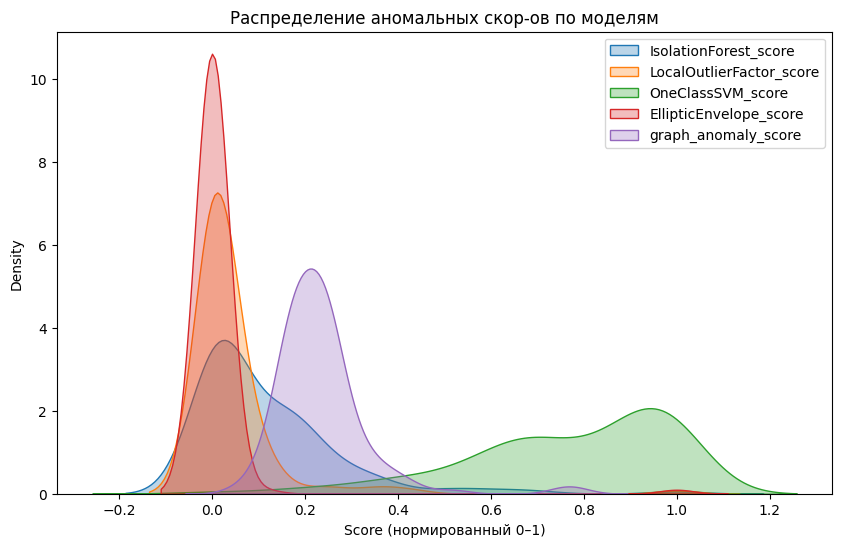

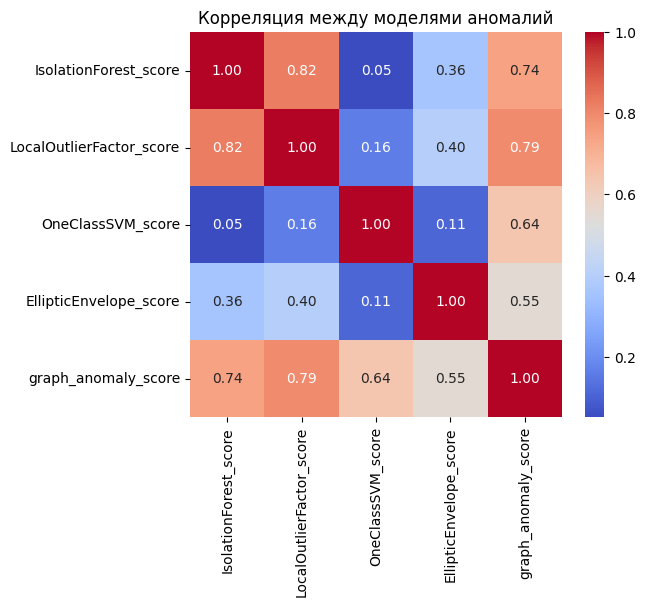


Совпадение топ-3% аномалий между моделями:
IsolationForest_score vs LocalOutlierFactor_score:   3 общих ИНН
IsolationForest_score vs OneClassSVM_score:   0 общих ИНН
IsolationForest_score vs EllipticEnvelope_score:   2 общих ИНН
IsolationForest_score vs graph_anomaly_score:   3 общих ИНН
LocalOutlierFactor_score vs OneClassSVM_score:   0 общих ИНН
LocalOutlierFactor_score vs EllipticEnvelope_score:   2 общих ИНН
LocalOutlierFactor_score vs graph_anomaly_score:   3 общих ИНН
OneClassSVM_score vs EllipticEnvelope_score:   0 общих ИНН
OneClassSVM_score vs graph_anomaly_score:   0 общих ИНН
EllipticEnvelope_score vs graph_anomaly_score:   2 общих ИНН


,mean,std,q97
model,,,



Корреляция моделей с ансамблем (чем выше, тем устойчивее):
LocalOutlierFactor_score    0.794852
IsolationForest_score       0.743540
OneClassSVM_score           0.639124
EllipticEnvelope_score      0.550178
Name: graph_anomaly_score, dtype: float64


In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) Распределение аномальных скор-ов
plt.figure(figsize=(10,6))
for col in [c for c in agg_all.columns if c.endswith("_score")]:
    sns.kdeplot(agg_all[col], label=col, fill=True, alpha=0.3)
plt.legend()
plt.title("Распределение аномальных скор-ов по моделям")
plt.xlabel("Score (нормированный 0–1)")
plt.show()

# 2) Корреляция между моделями
corr = agg_all[[c for c in agg_all.columns if c.endswith("_score")]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляция между моделями аномалий")
plt.show()

# 3) Совпадение топ-аномалий (по верхним 3%)
topk = int(len(agg_all)*0.03)
top_sets = {c: set(agg_all.sort_values(c,ascending=False).head(topk).index)
            for c in [c for c in agg_all.columns if c.endswith("_score")]}
overlaps = {m1+" vs "+m2: len(top_sets[m1] & top_sets[m2]) for i,m1 in enumerate(top_sets) for j,m2 in enumerate(top_sets) if j>i}
print("\nСовпадение топ-3% аномалий между моделями:")
for k,v in overlaps.items():
    print(f"{k:35s}: {v:3d} общих ИНН")

# 4) Усреднённый скор и дисперсия
summary = []
for c in [col for col in agg_all.columns if c.endswith("_score")]:
    s = agg_all[c]
    summary.append((c, s.mean(), s.std(), np.quantile(s,0.97)))
summary = pd.DataFrame(summary, columns=["model","mean","std","q97"]).set_index("model")
display(summary)

# 5) Простейший критерий "устойчивости"
# (высокая корреляция с ансамблем и разумное распределение)
agg_all["graph_anomaly_score"] = agg_all[[c for c in agg_all.columns if c.endswith("_score")]].mean(axis=1)
corr2 = corr["graph_anomaly_score"].drop("graph_anomaly_score", errors="ignore") if "graph_anomaly_score" in corr.columns else None
if corr2 is not None:
    print("\nКорреляция моделей с ансамблем (чем выше, тем устойчивее):")
    print(corr2.sort_values(ascending=False))


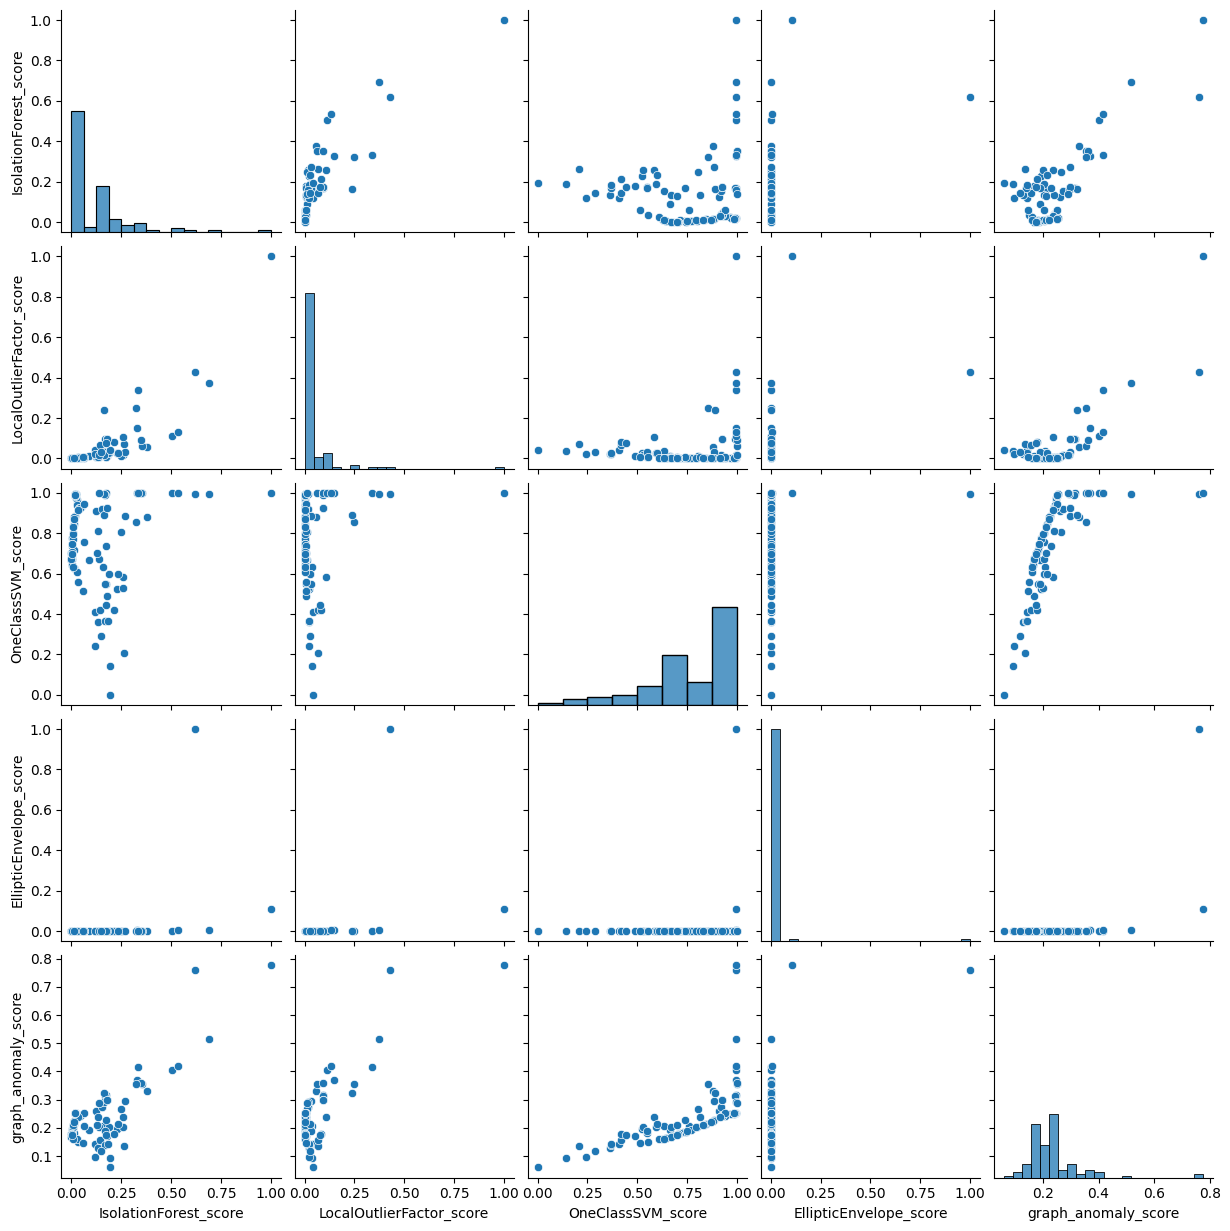

In [101]:
import seaborn as sns
sns.pairplot(scores_all[[c for c in scores_all.columns if c.endswith("_score")]])

In [102]:
top_iso = agg_all.sort_values("IsolationForest_score", ascending=False).head(10)
top_lof = agg_all.sort_values("LocalOutlierFactor_score", ascending=False).head(10)
display(top_iso, top_lof)

,debit_amount_count,debit_amount_sum,debit_amount_mean,debit_amount_std,debit_debit_roll_cnt_30d_mean,debit_debit_roll_mean_30d_mean,debit_debit_roll_std_30d_mean,debit_debit_amount_spike_ratio_7d_mean,debit_debit_tx_rate_spike_7d_mean,debit_debit_amount_volatility_30d_mean,...,in_unique,fan_out_ratio,fan_in_ratio,in_out_ratio,IsolationForest_score,LocalOutlierFactor_score,OneClassSVM_score,EllipticEnvelope_score,graph_anomaly_score,anomaly_flag
d877722ca4e40f98,2152.0,6.771678e+08,3.146691e+05,2.878643e+06,12.623606,664179.973598,1.901685e+06,1.271407,1.136342,2.917724,...,39.0,0.045539,0.069643,1.004671e+00,0.999998,1.000000,0.997024,1.089446e-01,0.776492,1
8d9e0be733f77f1c,223.0,3.538290e+08,1.586677e+06,9.526328e+06,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.004484,0.001017,3.201919e-01,0.691499,0.372108,0.993663,3.592611e-03,0.515216,1
6931e23e98703aa9,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.000000,0.003906,3.934273e+14,0.619638,0.427531,0.995626,1.000000e+00,0.760699,1
9d8f54ae3b88911b,32.0,4.984884e+07,1.557776e+06,3.764796e+06,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.031250,0.142857,4.574388e-01,0.535500,0.133098,0.997268,4.782535e-03,0.417662,1
80799e1a6646b6dc,9.0,7.698837e+07,8.554263e+06,5.258938e+06,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.111111,0.005814,4.207593e-02,0.506391,0.110572,0.997025,1.899937e-05,0.403502,0
032f0b4d2498f263,1.0,1.000000e+07,1.000000e+07,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.999999,0.076923,6.968814e-01,0.378798,0.057208,0.880794,2.866318e-05,0.329207,0
306735212f8e109d,1.0,1.100000e+07,1.100000e+07,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.0,0.999999,0.000000,9.090909e-14,0.354267,0.064004,0.998477,2.186456e-07,0.354187,0
53446acfe008dbf1,3.0,9.359197e+06,3.119732e+06,5.283674e+06,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.0,0.333333,0.000000,1.068468e-13,0.350986,0.091079,0.999991,2.186456e-07,0.360514,0
77af13772af29f14,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.000000,0.999999,6.076663e+12,0.332616,0.339914,0.997025,2.815240e-04,0.417459,0
365a9e654bc3d301,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.000000,0.071429,2.593570e+13,0.327615,0.148735,0.995943,3.624334e-03,0.368979,0


,debit_amount_count,debit_amount_sum,debit_amount_mean,debit_amount_std,debit_debit_roll_cnt_30d_mean,debit_debit_roll_mean_30d_mean,debit_debit_roll_std_30d_mean,debit_debit_amount_spike_ratio_7d_mean,debit_debit_tx_rate_spike_7d_mean,debit_debit_amount_volatility_30d_mean,...,in_unique,fan_out_ratio,fan_in_ratio,in_out_ratio,IsolationForest_score,LocalOutlierFactor_score,OneClassSVM_score,EllipticEnvelope_score,graph_anomaly_score,anomaly_flag
d877722ca4e40f98,2152.0,6.771678e+08,3.146691e+05,2.878643e+06,12.623606,664179.973598,1.901685e+06,1.271407,1.136342,2.917724,...,39.0,0.045539,0.069643,1.004671e+00,0.999998,1.000000,0.997024,0.108945,0.776492,1
6931e23e98703aa9,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.000000,0.003906,3.934273e+14,0.619638,0.427531,0.995626,1.000000,0.760699,1
8d9e0be733f77f1c,223.0,3.538290e+08,1.586677e+06,9.526328e+06,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.004484,0.001017,3.201919e-01,0.691499,0.372108,0.993663,0.003593,0.515216,1
77af13772af29f14,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.000000,0.999999,6.076663e+12,0.332616,0.339914,0.997025,0.000282,0.417459,0
6ef5667d7851dcbc,20.0,2.320000e+07,1.160000e+06,3.218368e+05,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.050000,0.999999,1.293103e-01,0.322279,0.249398,0.854663,0.000169,0.356627,0
b7f7935acecc2c89,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.000000,0.999999,2.329840e+12,0.162005,0.240171,0.890138,0.000040,0.323088,0
365a9e654bc3d301,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.000000,0.071429,2.593570e+13,0.327615,0.148735,0.995943,0.003624,0.368979,0
9d8f54ae3b88911b,32.0,4.984884e+07,1.557776e+06,3.764796e+06,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.031250,0.142857,4.574388e-01,0.535500,0.133098,0.997268,0.004783,0.417662,1
80799e1a6646b6dc,9.0,7.698837e+07,8.554263e+06,5.258938e+06,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.111111,0.005814,4.207593e-02,0.506391,0.110572,0.997025,0.000019,0.403502,0
3a9c5401f637dd8d,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.000000,0.100000,2.017811e+13,0.258751,0.105741,0.585183,0.001756,0.237858,0


✅ Фичей для анализа: 60, наблюдений: 2688
⏳ Обучаем IsolationForest ...
  min=0.000 max=1.000 mean=0.368 std=0.192
⏳ Обучаем LocalOutlierFactor ...
  min=0.000 max=1.000 mean=0.016 std=0.042
⏳ Обучаем OneClassSVM ...
  min=0.000 max=1.000 mean=0.900 std=0.138
⏳ Обучаем EllipticEnvelope ...
  min=0.000 max=1.000 mean=0.002 std=0.032
⏳ Обучаем HBOS ...
  min=0.000 max=1.000 mean=0.634 std=0.175
⏳ Обучаем COPOD ...
  min=0.000 max=1.000 mean=0.661 std=0.181


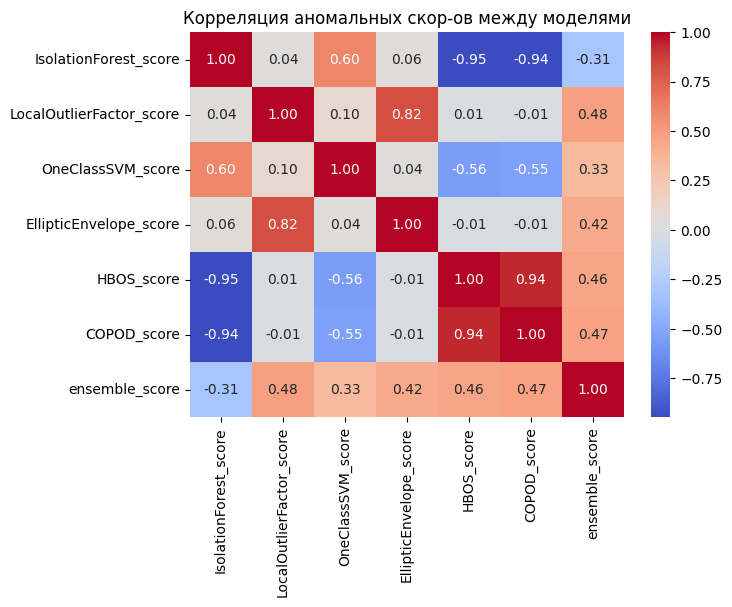

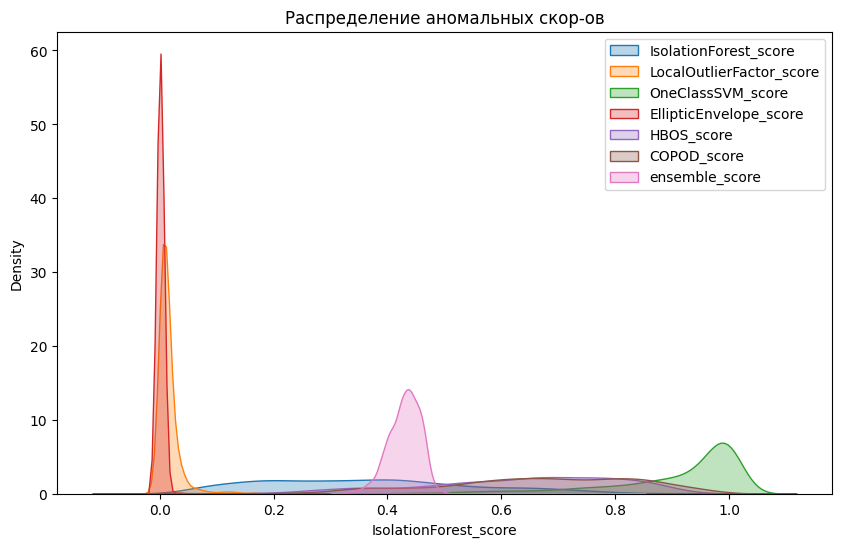


Сводный порог: 0.473 | Аномальных транзакций: 81 из 2688

=== Сводка по стабильности моделей ===
                              mean       std  corr_with_ensemble
ensemble_score            0.430180  0.031133            1.000000
LocalOutlierFactor_score  0.015979  0.042456            0.479928
COPOD_score               0.661387  0.181205            0.473155
HBOS_score                0.634493  0.175081            0.458311
EllipticEnvelope_score    0.001978  0.031792            0.422729
OneClassSVM_score         0.899731  0.138382            0.333108
IsolationForest_score     0.367514  0.192395           -0.307147

🏆 Лучшая модель по согласованности и разделимости: ensemble_score

=== Комплексная метрика устойчивости (выше — лучше) ===
                              mean       std  corr_with_ensemble  \
EllipticEnvelope_score    0.001978  0.031792            0.422729   
LocalOutlierFactor_score  0.015979  0.042456            0.479928   
IsolationForest_score     0.367514  0.192395          

In [110]:
# ============================================================
#  Выявление аномалий по всему датасету (числовые + текстовые признаки)
#  Сравнение моделей: IsolationForest, LOF, SVM, HBOS, COPOD, EllipticEnvelope
#  + Корректное масштабирование (RobustScaler для чисел, Quantile→Normal для SVD)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

warnings.filterwarnings("ignore")

# --- PyOD (если есть) ---
PYOD_OK = False
try:
    from pyod.models.hbos import HBOS
    from pyod.models.copod import COPOD
    PYOD_OK = True
except ImportError:
    print("⚠️ PyOD не найден, HBOS/COPOD пропущены")

RANDOM_STATE = 42

# ---------- 1) Подготовка данных ----------
svd_cols = [c for c in df.columns if c.startswith("purpose_svd_")]
base_feat = [
    "amount","round_large_amount","day_of_week","is_weekend","is_month_end",
    "purpose_len","digit_share","has_contract_no","is_foreign_lang",
    "purpose_risk_score"
]
feat_B = base_feat + svd_cols

# гарантируем наличие столбцов
for c in feat_B:
    if c not in df.columns:
        df[c] = 0.0

# приводим типы бинарных к float
for c in ["round_large_amount","is_weekend","is_month_end","has_contract_no","is_foreign_lang"]:
    if c in df.columns:
        df[c] = df[c].astype(float)

# делим фичи на числовые и SVD-компоненты
numeric_cols = [c for c in feat_B if c not in svd_cols]
svd_cols = [c for c in feat_B if c.startswith("purpose_svd_")]

# препроцессор: робаст для чисел + квантиль к нормальному для SVD
preprocessor = ColumnTransformer([
    ("num", RobustScaler(), numeric_cols),
    ("svd", QuantileTransformer(output_distribution="normal", random_state=RANDOM_STATE), svd_cols)
], remainder="drop")

X_raw = df[feat_B].replace([np.inf, -np.inf], np.nan).fillna(0.0)
X_scaled = preprocessor.fit_transform(X_raw)

print(f"✅ Фичей для анализа: {X_scaled.shape[1]}, наблюдений: {X_scaled.shape[0]}")
if len(svd_cols) == 0:
    print("ℹ️ Внимание: SVD-компоненты отсутствуют, масштабирование выполнено только для числовых фичей.")

# ---------- 2) Обучение моделей ----------
models = {
    "IsolationForest": IsolationForest(
        n_estimators=400, contamination=0.03, random_state=RANDOM_STATE, n_jobs=-1
    ),
    "LocalOutlierFactor": LocalOutlierFactor(
        n_neighbors=20, contamination=0.03, novelty=True
    ),
    "OneClassSVM": OneClassSVM(kernel="rbf", gamma=0.05, nu=0.03),
    "EllipticEnvelope": EllipticEnvelope(contamination=0.03, random_state=RANDOM_STATE)
}
if PYOD_OK:
    models["HBOS"] = HBOS(alpha=0.1)
    models["COPOD"] = COPOD()

scores_df = pd.DataFrame(index=df.index)

for name, model in models.items():
    print(f"⏳ Обучаем {name} ...")
    try:
        model.fit(X_scaled)
        # приводим "чем выше, тем более аномально"
        if hasattr(model, "decision_function"):
            raw = -model.decision_function(X_scaled)
        elif hasattr(model, "decision_scores_"):
            raw = model.decision_scores_
        else:
            raw = -model.score_samples(X_scaled)
    except Exception as e:
        print(f"⚠️ {name} не удалось обучить: {e}")
        continue

    raw = np.nan_to_num(raw, nan=0.0, posinf=0.0, neginf=0.0)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-6)  # 0..1
    scores_df[name+"_score"] = s
    print(f"  min={s.min():.3f} max={s.max():.3f} mean={s.mean():.3f} std={s.std():.3f}")

# ---------- 3) Анализ результатов ----------
if len(scores_df.columns) == 0:
    raise RuntimeError("❌ Ни одна модель не отработала, таблица скор-ов пуста.")

# усреднённый ансамбль (безопасно, даже если 1 модель)
scores_df["ensemble_score"] = scores_df.mean(axis=1)

# корреляции между моделями (только если больше 1 модели)
if scores_df.shape[1] > 1:
    corr = scores_df.corr()
    plt.figure(figsize=(7,5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Корреляция аномальных скор-ов между моделями")
    plt.show()
else:
    corr = pd.DataFrame(index(scores_df.columns), columns(scores_df.columns))
    print("⚠️ Недостаточно моделей для расчёта корреляции.")

# распределения скор-ов
plt.figure(figsize=(10,6))
for c in scores_df.columns:
    sns.kdeplot(scores_df[c], label=c, fill=True, alpha=0.3)
plt.legend()
plt.title("Распределение аномальных скор-ов")
plt.show()

# ---------- 4) Усреднённый ансамбль ----------
thr = np.quantile(scores_df["ensemble_score"], 0.97)
df["global_anomaly_score"] = scores_df["ensemble_score"]
df["global_anomaly_flag"] = (df["global_anomaly_score"] >= thr).astype(int)

print(f"\nСводный порог: {thr:.3f} | Аномальных транзакций: {df['global_anomaly_flag'].sum()} из {len(df)}")

# ---------- 5) Выбор лучшей модели ----------
corr_with_ens = scores_df.corrwith(scores_df["ensemble_score"]).dropna()
summary = pd.DataFrame({
    "mean": scores_df.mean(),
    "std": scores_df.std(),
    "corr_with_ensemble": corr_with_ens
}).sort_values("corr_with_ensemble", ascending=False, na_position="last")

print("\n=== Сводка по стабильности моделей ===")
print(summary)

best_model = summary.index[0] if not summary.empty else None
print(f"\n🏆 Лучшая модель по согласованности и разделимости: {best_model or 'не определена'}")

# (доп) комплексная метрика устойчивости
summary["score_quality"] = summary["std"].abs() * summary["corr_with_ensemble"].abs() / (summary["mean"] + 1e-6)
summary = summary.sort_values("score_quality", ascending=False)
print("\n=== Комплексная метрика устойчивости (выше — лучше) ===")
print(summary[["mean","std","corr_with_ensemble","score_quality"]])

# ---------- 6) Сохранение результатов ----------
df.to_csv("transactions_anomaly_scores.csv", index=False)
print("\n✅ Результаты сохранены: transactions_anomaly_scores.csv")
print("Добавлены колонки: global_anomaly_score, global_anomaly_flag")
print(f"Лучшая модель: {best_model}")


# ---------- 7) Топ-50 по лучшей модели + сводки по ИНН ----------
# выбираем лучшую модель по комплексной метрике (если уже посчитана)
if "score_quality" in summary.columns:
    best_model = summary["score_quality"].idxmax()
else:
    # fallback: по корреляции с ансамблем
    best_model = summary["corr_with_ensemble"].idxmax()

# у моделей в scores_df имена вида "<Model>_score"
if not best_model.endswith("_score"):
    best_model = best_model + "_score"

if best_model not in scores_df.columns:
    # если в summary попало имя без "_score" или модели нет (редко) — fallback на ensemble
    best_model = "ensemble_score"
print(f"\n🎯 Лучшая модель для отбора топ-аномалий: {best_model}")

# добавим скор лучшей модели в df (на всякий случай)
df[best_model] = scores_df[best_model].values

# состав ключевых колонок для отображения/сохранения (фильтруем по наличию)
_cols_pref = [
    "date","debit_inn","credit_inn","amount","purpose",
    "purpose_risk_score","purpose_len","digit_share",
    "is_weekend","is_month_end","round_large_amount"
]
cols_show = [c for c in _cols_pref + [best_model] if c in df.columns]

# Топ-50 подозрительных транзакций по лучшей модели
top_n = 50
top_anom = df.sort_values(best_model, ascending=False).head(top_n).copy()

print(f"\n=== Топ-{top_n} подозрительных транзакций ({best_model}) ===")
print(top_anom[cols_show])

# сохраняем
fname_tx = f"top_{top_n}_anomalies_{best_model}.csv"
top_anom[cols_show].to_csv(fname_tx, index=False, encoding="utf-8-sig")
print(f"✅ Сохранено: {fname_tx}")

# ---------- 8) Группировки по ИНН (отправитель/получатель) ----------
# функции-агрегаторы
def _agg_block(df_block, key):
    return (df_block
            .groupby(key)
            .agg(
                n_tx=("amount","size") if "amount" in df_block.columns else ("date","size"),
                total_amount=("amount","sum") if "amount" in df_block.columns else ("amount","sum"),
                mean_amount=("amount","mean") if "amount" in df_block.columns else ("amount","mean"),
                mean_score=(best_model,"mean"),
                p97_score=(best_model, lambda s: np.quantile(s, 0.97))
            )
            .reset_index()
            .sort_values(["p97_score","mean_score","n_tx"], ascending=[False, False, False])
           )

# топ-отправители (debit_inn) среди топ-аномалий
if "debit_inn" in df.columns:
    top_debit = _agg_block(top_anom, "debit_inn")
    print("\n=== ТОП отправителей (debit_inn) среди топ-аномалий ===")
    print(top_debit.head(20))
    fname_debit = f"top_{top_n}_anomalies_debit_inn_{best_model}.csv"
    top_debit.to_csv(fname_debit, index=False, encoding="utf-8-sig")
    print(f"✅ Сохранено: {fname_debit}")

# топ-получатели (credit_inn) среди топ-аномалий
if "credit_inn" in df.columns:
    top_credit = _agg_block(top_anom, "credit_inn")
    print("\n=== ТОП получателей (credit_inn) среди топ-аномалий ===")
    print(top_credit.head(20))
    fname_credit = f"top_{top_n}_anomalies_credit_inn_{best_model}.csv"
    top_credit.to_csv(fname_credit, index=False, encoding="utf-8-sig")
    print(f"✅ Сохранено: {fname_credit}")

# (опционально) итог: сколько раз ИНН попал в топ-50 как sender/receiver
if "debit_inn" in df.columns and "credit_inn" in df.columns:
    deb_counts = top_anom["debit_inn"].value_counts().rename("as_sender")
    cred_counts = top_anom["credit_inn"].value_counts().rename("as_receiver")
    inn_mix = pd.concat([deb_counts, cred_counts], axis=1).fillna(0).astype(int)
    inn_mix["total_hits"] = inn_mix.sum(axis=1)
    inn_mix = inn_mix.sort_values("total_hits", ascending=False)
    print("\n=== ИНН с наибольшим числом попаданий в топ-50 (sender/receiver) ===")
    print(inn_mix.head(20))
    fname_mix = f"top_{top_n}_anomalies_inn_mix_{best_model}.csv"
    inn_mix.to_csv(fname_mix, encoding="utf-8-sig")
    print(f"✅ Сохранено: {fname_mix}")



=== Комплексная метрика устойчивости (выше — лучше) ===
                              mean       std  corr_with_ensemble  \
EllipticEnvelope_score    0.001978  0.031792            0.422729   
LocalOutlierFactor_score  0.015979  0.042456            0.479928   
IsolationForest_score     0.367514  0.192395           -0.307147   
COPOD_score               0.661387  0.181205            0.473155   
HBOS_score                0.634493  0.175081            0.458311   
ensemble_score            0.430180  0.031133            1.000000   
OneClassSVM_score         0.899731  0.138382            0.333108   

                          score_quality  
EllipticEnvelope_score         6.792591  
LocalOutlierFactor_score       1.275062  
IsolationForest_score          0.160792  
COPOD_score                    0.129634  
HBOS_score                     0.126466  
ensemble_score                 0.072372  
OneClassSVM_score              0.051233  


<Figure size 900x500 with 0 Axes>

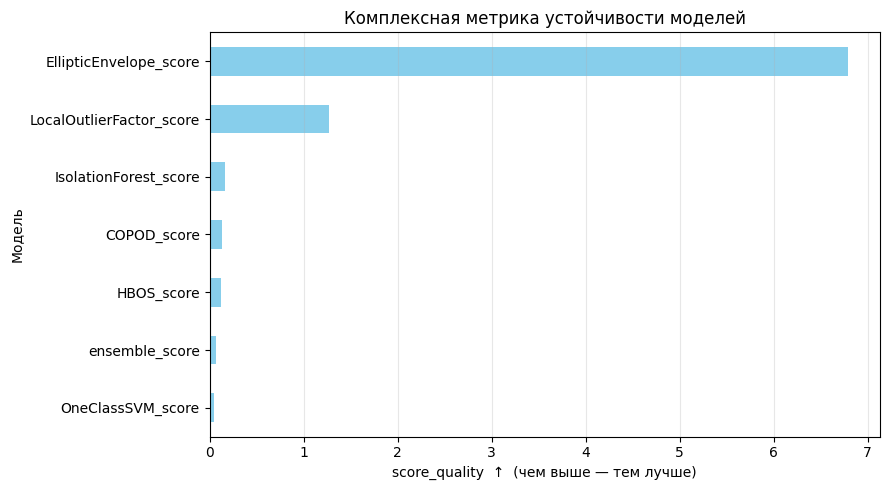

In [107]:
print("\n=== Комплексная метрика устойчивости (выше — лучше) ===")
print(summary[["mean","std","corr_with_ensemble","score_quality"]])

# === Визуализация комплексной метрики ===
plt.figure(figsize=(9,5))
(
    summary[["score_quality"]]
    .sort_values("score_quality", ascending=False)
    .plot(kind="barh", color="skyblue", legend=False, figsize=(9,5))
)
plt.title("Комплексная метрика устойчивости моделей")
plt.xlabel("score_quality  ↑  (чем выше — тем лучше)")
plt.ylabel("Модель")
plt.gca().invert_yaxis()
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# =========================
# GCN Autoencoder (GAE) для AML на транзакциях по ИНН
# ОДНА ЯЧЕЙКА С ПОДРОБНЫМИ КОММЕНТАРИЯМИ
# =========================

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from tqdm import tqdm
# 1) ПРЕПРОЦЕССИНГ → строим граф ИНН–ИНН и фичи узлов
# ------------------------------------------------------------------------------
# Узлы = ИНН (и дебитор, и кредитор в одном пространстве узлов)
inn_series = pd.concat([df['debit_inn'], df['credit_inn']], ignore_index=True)
unique_inn = pd.Index(inn_series.dropna().unique())
inn2id = {inn: i for i, inn in enumerate(unique_inn)}
num_nodes = len(unique_inn)

# Рёбра: из debit_inn в credit_inn
edges_src = df['debit_inn'].map(inn2id)
edges_dst = df['credit_inn'].map(inn2id)
mask_valid = edges_src.notna() & edges_dst.notna()
edges_src = edges_src[mask_valid].astype(int).values
edges_dst = edges_dst[mask_valid].astype(int).values

edge_index = torch.tensor([edges_src, edges_dst], dtype=torch.long)
# Сделаем граф неориентированным (часто устойчивее для GAE): добавим обратные рёбра
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

# Фичи узлов: агрегируем транзакционные признаки в профили ИНН
# Берём только числовые столбцы, исключая явные идентификаторы/текст
exclude_cols = {
    'date','debit_account','debit_name','debit_inn',
    'credit_account','credit_name','credit_inn','purpose'
}
numeric_cols = [c for c in df.columns
                if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]
# Если какие-то фичи в NaN — заменим нулями
df_num = df[numeric_cols].copy().fillna(0)

# Агрегируем отдельно для дебитора и кредитора, затем объединим и усредним
agg_debit = df.groupby('debit_inn')[numeric_cols].mean()
agg_credit = df.groupby('credit_inn')[numeric_cols].mean()

# Приведём к единому индексу всех ИНН
agg_debit = agg_debit.reindex(unique_inn, fill_value=0)
agg_credit = agg_credit.reindex(unique_inn, fill_value=0)

# Финальные фичи узла (ИНН): среднее (можно и конкатенировать + нормализовать)
node_features = (agg_debit.values + agg_credit.values) / 2.0

# Масштабируем (важно для стабильности обучения)
scaler = StandardScaler()
node_features = scaler.fit_transform(node_features)

x = torch.tensor(node_features, dtype=torch.float)

data_pg = Data(x=x, edge_index=edge_index)
print(data_pg)

# ------------------------------------------------------------------------------
# 2) МОДЕЛЬ: GCN-энкодер + Inner-Product декодер, обучение GAE
# ------------------------------------------------------------------------------
class GCNEncoder(nn.Module):
    def __init__(self, in_ch, hidden=64, out_ch=32, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hidden)
        self.conv2 = GCNConv(hidden, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        z = self.conv2(h, edge_index)
        return z  # эмбеддинги узлов

def recon_loss(z, edge_index, num_nodes, neg_ratio=1.0):
    # Позитивы: реальные рёбра (убираем дубликаты для устойчивости)
    # (можно оставить как есть — разницы немного)
    pos_i, pos_j = edge_index

    # Негативы: случайные пары без ребра (negative sampling)
    num_neg = int(pos_i.numel() * neg_ratio)
    neg_edge_index = negative_sampling(
        edge_index=edge_index, num_nodes=num_nodes, num_neg_samples=num_neg, method='sparse'
    )

    # Логиты = скалярное произведение z_i и z_j
    pos_logits = (z[pos_i] * z[pos_j]).sum(dim=-1)
    neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=-1)

    # BCE-лосс (with logits)
    pos_loss = F.binary_cross_entropy_with_logits(pos_logits, torch.ones_like(pos_logits))
    neg_loss = F.binary_cross_entropy_with_logits(neg_logits, torch.zeros_like(neg_logits))
    return pos_loss + neg_loss

device = torch.device('cpu')
model = GCNEncoder(in_ch=data_pg.num_features, hidden=64, out_ch=32, dropout=0.3).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

x = data_pg.x.to(device)
ei = data_pg.edge_index.to(device)

epochs = 300  # при большом графе можно 100–200
for ep in tqdm(range(1, epochs + 1), desc="Training", unit="epoch"):
    model.train()
    opt.zero_grad()
    z = model(x, ei)
    loss = recon_loss(z, ei, num_nodes=data_pg.num_nodes, neg_ratio=1.0)
    loss.backward()
    opt.step()
    
    if ep % 50 == 0 or ep == 1:
        tqdm.write(f"Epoch {ep:03d} | Loss: {loss.item():.4f}")
# Финальные эмбеддинги
model.eval()
with torch.no_grad():
    z = model(x, ei)  # [num_nodes, d]

# ------------------------------------------------------------------------------
# 3) СКОРИНГ АНОМАЛИЙ
#   A) ребра (переводы): score_edge = 1 - σ(z_u · z_v)
#   B) узлы (ИНН): два простых скора
#       - среднее (1 - p) по инцидентным рёбрам (как "плохо объяснимая" окрестность)
#       - изолированность = 1 - среднее косинусное сходство с соседями
# ------------------------------------------------------------------------------
sigmoid = torch.sigmoid

# A) Edge scores (для ИСХОДНЫХ переводов без добавленных обратных рёбер)
orig_src = torch.tensor(edges_src, dtype=torch.long, device=device)
orig_dst = torch.tensor(edges_dst, dtype=torch.long, device=device)
with torch.no_grad():
    edge_logits = (z[orig_src] * z[orig_dst]).sum(dim=-1)
    edge_p = sigmoid(edge_logits)
edge_score = (1.0 - edge_p).cpu().numpy()  # выше — подозрительнее

# Сгруппируем по (debit_inn, credit_inn): берём средний score, чтобы учесть множественные транзакции
edge_keys = pd.MultiIndex.from_arrays([df.loc[mask_valid, 'debit_inn'].values,
                                       df.loc[mask_valid, 'credit_inn'].values],
                                      names=['debit_inn','credit_inn'])
edge_df = pd.DataFrame({'edge_score': edge_score}, index=edge_keys).groupby(level=[0,1]).mean()
edge_top = edge_df.sort_values('edge_score', ascending=False).head(20)
print("\nTop-20 подозрительных связей (ИНН→ИНН) по GAE edge_score:")
display(edge_top)

# B1) Node score по «плохо объяснимым» рёбрам
#    node_score(i) = среднее (1 - p_ij) по всем исходящим и входящим рёбрам узла i
num_nodes = data_pg.num_nodes
node_accum = np.zeros(num_nodes, dtype=np.float64)
node_cnt   = np.zeros(num_nodes, dtype=np.int64)

# учтём только оригинальные направления (как в edge_top)
for s, d, sc in zip(edges_src, edges_dst, edge_score):
    node_accum[s] += sc; node_cnt[s] += 1
    node_accum[d] += sc; node_cnt[d] += 1
node_score_edges = np.divide(node_accum, np.maximum(node_cnt, 1))

# B2) Node isolation по косинусу к соседям
with torch.no_grad():
    zn = F.normalize(z, dim=1)
# считаем средний косинус к соседям (по неориентированным рёбрам)
cos_accum = np.zeros(num_nodes, dtype=np.float64)
cos_cnt   = np.zeros(num_nodes, dtype=np.int64)
ei_cpu = ei.cpu().numpy()
for u, v in zip(ei_cpu[0], ei_cpu[1]):
    cos = float((zn[u] * zn[v]).sum().cpu())
    cos_accum[u] += cos; cos_cnt[u] += 1
# 1 - средний косинус → выше = более изолирован
node_isolation = 1.0 - np.divide(cos_accum, np.maximum(cos_cnt, 1))

# Сводим узловые скора в таблицу
node_tbl = pd.DataFrame({
    'inn': unique_inn.values,
    'edge_based_score': node_score_edges,
    'isolation_score': node_isolation
}).set_index('inn')
node_tbl['node_score'] = 0.5*node_tbl['edge_based_score'] + 0.5*node_tbl['isolation_score']
node_top = node_tbl.sort_values('node_score', ascending=False).head(20)

print("\nTop-20 подозрительных ИНН по узловому скору (комбинация edge_based + isolation):")
display(node_top)

# ------------------------------------------------------------------------------
# 4) ПОДСКАЗКИ ПО ИНТЕРПРЕТАЦИИ / АДАПТАЦИИ
# ------------------------------------------------------------------------------
# - Для больших графов уменьшай epochs до 100–200, или пробуй GraphSAGE вместо GCN.
# - Если важна НАПРАВЛЕННОСТЬ, можно обучать на исходном направленном графе (без добавления обратных рёбер)
#   и/или использовать декодер-MLP на [z_u, z_v, edge_features] — так ты учтёшь сумму/время транзакции.
# - В проде часто используют: эмбеддинги z -> как фичи в LightGBM/XGBoost + правила комплаенса.
# - Метрики в AML: Precision@K, доля выявленного риска, нагрузка на проверяющих (сколько алертов/день).
# ------------------------------------------------------------------------------



In [2]:
!pip install torch